# Protein Folding Principles Dataset

In [1]:
import matplotlib.pyplot as plt

In [ ]:
#Change root directory to the project root
#This is necessary to import modules from the project
#without having to install them

import sys
import os
import numpy as np
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [3]:
## Interactive reloading
#This is useful for Jupyter notebooks to automatically reload modules

%load_ext autoreload
%autoreload 2

## Get PDB codes for high quality structures using PISCES

In [4]:
from dataset.pisces import fetch_pisces_table, get_filtered_pdb_codes

# Fetch and filter
pisces_df = fetch_pisces_table()
pdb_ids = get_filtered_pdb_codes(pisces_df)

# Preview results
print(f"Found {len(pdb_ids)} high-quality structures with pdb codes.")
print(pdb_ids[:10])


Detected PISCES columns: ['PDBchain', 'len', 'method', 'resol', 'rfac', 'freerfac']
Found 11116 high-quality structures with pdb codes.
['5D8V', '5NW3', '1UCS', '3X2M', '2VB1', '1US0', '6E6O', '6S2M', '1R6J', '4REK']


## Find bb, ba, ab motifs and their chirality in PDB entries

In [ ]:
from dataset.io_utils import fetch_mmcif_file, run_dssp_on_mmcif
from dataset.motif_logic import (
    detect_hairpins,
    assign_beta_chirality_strand_axis,
    assign_beta_chirality_local,
    detect_ab_motifs, 
    assign_ab_chirality,
    detect_ba_motifs, 
    assign_ba_chirality,
)
import pandas as pd
import os
from tqdm import tqdm 

bb_motifs_by_strandaxis = []
bb_motifs_local = []
ab_motifs = []
ba_motifs = []

for pdb_id in tqdm(pdb_ids, desc="Processing PDBs"):
    pdb_path = fetch_mmcif_file(pdb_id, outdir="./pdb_files")
    try:
        model, dssp_df = run_dssp_on_mmcif(
            pdb_path,
            dssp_exe="/opt/anaconda3/envs/folding-dssp/bin/mkdssp",
        )
        if dssp_df is None:
            print(f"DSSP failed for {pdb_id}. Skipping.")
            continue

        # BB motifs
        hairpin_annotations = detect_hairpins(dssp_df)
        # Strand-axis method
        df_strandaxis = assign_beta_chirality_strand_axis(
            model, dssp_df, hairpin_annotations
        )
        bb_motifs_by_strandaxis.append(df_strandaxis)

        # Local backbone method
        df_local = assign_beta_chirality_local(
            model, dssp_df, hairpin_annotations
        )
        bb_motifs_local.append(df_local)

        # AB motifs
        ab_annotations = detect_ab_motifs(dssp_df)
        # Assign orientation (parallel vs antiparallel) using local-geometry definition
        df_ab = assign_ab_chirality(model, dssp_df, ab_annotations)
        ab_motifs.append(df_ab)

        # BA motifs
        ba_annotations = detect_ba_motifs(dssp_df)
        # Assign orientation (parallel vs antiparallel) using local-geometry definition
        df_ba = assign_ba_chirality(model, dssp_df, ba_annotations)
        ba_motifs.append(df_ba)

    except Exception as e:
        print(f"Error processing {pdb_id}: {e}")
        continue
    finally:
        pass
        # if os.path.exists(pdb_path):
        #     os.remove(pdb_path)

bb_motifs_by_strandaxis = pd.concat(bb_motifs_by_strandaxis, ignore_index=True)
bb_motifs_local = pd.concat(bb_motifs_local, ignore_index=True)
ab_motifs = pd.concat(ab_motifs, ignore_index=True)
ba_motifs = pd.concat(ba_motifs, ignore_index=True)

bb_motifs_local.head(10)


Processing PDBs:   1%|          | 94/11116 [00:33<1:19:52,  2.30it/s]

Error processing 7OUZ: (' ', np.int64(304), ' ')


Processing PDBs:   2%|▏         | 221/11116 [01:20<55:39,  3.26it/s]  

Error processing 3D1P: (' ', np.int64(30), ' ')


Processing PDBs:   4%|▍         | 469/11116 [03:05<1:30:41,  1.96it/s]

Error processing 3MCW: (' ', np.int64(132), ' ')


Processing PDBs:   4%|▍         | 476/11116 [03:08<1:04:42,  2.74it/s]

Error processing 2R0X: (' ', np.int64(11), ' ')


Processing PDBs:   4%|▍         | 486/11116 [03:11<52:25,  3.38it/s]  

Error processing 4Q68: (' ', np.int64(245), ' ')


Processing PDBs:   4%|▍         | 488/11116 [03:12<58:47,  3.01it/s]

Error processing 5TFQ: (' ', np.int64(151), ' ')


Processing PDBs:   6%|▌         | 686/11116 [04:38<1:12:16,  2.41it/s]

Error processing 3G5T: (' ', np.int64(54), ' ')


Processing PDBs:   6%|▌         | 689/11116 [04:39<1:01:59,  2.80it/s]/opt/anaconda3/envs/folding-dssp/lib/python3.9/site-packages/Bio/PDB/DSSP.py:199: UserWarning: DSSP could not be created due to an error:
bad lexical cast: source type value could not be interpreted as target

  warnings.warn(err)
/Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 2yln: DSSP failed to produce an output
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:   6%|▌         | 690/11116 [04:39<55:07,  3.15it/s]  

DSSP failed for 2YLN. Skipping.


Processing PDBs:   7%|▋         | 776/11116 [05:19<1:05:29,  2.63it/s]

Error processing 3DLC: (' ', np.int64(77), ' ')


Processing PDBs:   7%|▋         | 781/11116 [05:21<1:13:57,  2.33it/s]

Error processing 4N03: (' ', np.int64(129), ' ')


Processing PDBs:   7%|▋         | 815/11116 [05:34<1:03:56,  2.68it/s]

Error processing 2R01: (' ', np.int64(143), ' ')


Processing PDBs:   8%|▊         | 873/11116 [05:54<1:31:14,  1.87it/s]

Error processing 4RJZ: (' ', np.int64(270), ' ')


Processing PDBs:   9%|▊         | 962/11116 [06:30<1:09:54,  2.42it/s]

Error processing 3IR4: (' ', np.int64(63), ' ')


Processing PDBs:   9%|▉         | 974/11116 [06:35<1:09:12,  2.44it/s]

Error processing 2IAY: (' ', np.int64(28), ' ')


Processing PDBs:   9%|▉         | 994/11116 [06:45<1:36:05,  1.76it/s]

Error processing 1XDN: (' ', np.int64(314), ' ')


Processing PDBs:   9%|▉         | 996/11116 [06:46<1:16:43,  2.20it/s]

Error processing 3OHE: (' ', np.int64(68), ' ')


Processing PDBs:   9%|▉         | 1022/11116 [06:57<1:04:20,  2.61it/s]

Error processing 4EBG: (' ', np.int64(107), ' ')


Processing PDBs:   9%|▉         | 1025/11116 [06:59<1:39:28,  1.69it/s]

Error processing 4WWH: (' ', np.int64(90), ' ')


Processing PDBs:   9%|▉         | 1036/11116 [07:04<1:07:14,  2.50it/s]

Error processing 5I39: (' ', np.int64(440), ' ')


Processing PDBs:   9%|▉         | 1048/11116 [07:09<59:31,  2.82it/s]  

Error processing 4FR9: (' ', np.int64(43), ' ')


Processing PDBs:  10%|▉         | 1079/11116 [07:23<1:07:06,  2.49it/s]

Error processing 4GWB: (' ', np.int64(15), ' ')


Processing PDBs:  10%|▉         | 1095/11116 [07:30<1:04:01,  2.61it/s]

Error processing 1VK1: (' ', np.int64(133), ' ')


Processing PDBs:  10%|█         | 1136/11116 [07:43<49:40,  3.35it/s]  

Error processing 3SG0: (' ', np.int64(143), ' ')


Processing PDBs:  11%|█         | 1214/11116 [08:16<56:35,  2.92it/s]  

Error processing 3F7X: (' ', np.int64(53), ' ')


Processing PDBs:  11%|█▏        | 1253/11116 [08:34<1:36:31,  1.70it/s]

Error processing 3GIU: (' ', np.int64(119), ' ')


Processing PDBs:  11%|█▏        | 1263/11116 [08:40<1:26:57,  1.89it/s]

Error processing 4PZ0: (' ', np.int64(257), ' ')


Processing PDBs:  12%|█▏        | 1301/11116 [08:57<1:18:21,  2.09it/s]

Error processing 3R6D: (' ', np.int64(63), ' ')


Processing PDBs:  12%|█▏        | 1306/11116 [09:00<1:30:48,  1.80it/s]

Error processing 3SGG: (' ', np.int64(233), ' ')


Processing PDBs:  12%|█▏        | 1324/11116 [09:07<1:05:41,  2.48it/s]

Error processing 3I2V: (' ', np.int64(113), ' ')


Processing PDBs:  12%|█▏        | 1353/11116 [09:19<1:02:12,  2.62it/s]

Error processing 5D78: (' ', np.int64(371), ' ')


Processing PDBs:  13%|█▎        | 1406/11116 [09:41<1:09:42,  2.32it/s]

Error processing 5ULB: (' ', np.int64(273), ' ')


Processing PDBs:  13%|█▎        | 1433/11116 [09:53<1:02:05,  2.60it/s]

Error processing 2PC1: (' ', np.int64(137), ' ')


Processing PDBs:  13%|█▎        | 1436/11116 [09:55<1:16:31,  2.11it/s]

Error processing 4WLH: (' ', np.int64(247), ' ')


Processing PDBs:  13%|█▎        | 1498/11116 [10:21<1:06:23,  2.41it/s]

Error processing 4JJA: (' ', np.int64(117), ' ')


Processing PDBs:  14%|█▎        | 1528/11116 [10:33<55:09,  2.90it/s]  

Error processing 3NBM: (' ', np.int64(536), ' ')


Processing PDBs:  14%|█▍        | 1534/11116 [10:37<1:40:15,  1.59it/s]

Error processing 3KKF: (' ', np.int64(60), ' ')


Processing PDBs:  14%|█▍        | 1548/11116 [10:43<51:19,  3.11it/s]  

Error processing 3HM4: (' ', np.int64(23), ' ')


Processing PDBs:  14%|█▍        | 1557/11116 [10:46<45:41,  3.49it/s]  

Error processing 3EBT: (' ', np.int64(125), ' ')


Processing PDBs:  15%|█▍        | 1660/11116 [11:30<47:42,  3.30it/s]  

Error processing 4CGS: (' ', np.int64(44), ' ')


Processing PDBs:  15%|█▌        | 1712/11116 [11:47<54:25,  2.88it/s]  

Error processing 2EHP: (' ', np.int64(64), ' ')


Processing PDBs:  16%|█▌        | 1733/11116 [11:54<51:07,  3.06it/s]  

Error processing 3BLN: (' ', np.int64(88), ' ')


Processing PDBs:  16%|█▌        | 1801/11116 [12:22<1:53:06,  1.37it/s]

Error processing 1KKO: (' ', np.int64(184), ' ')


Processing PDBs:  17%|█▋        | 1839/11116 [12:42<56:12,  2.75it/s]  

Error processing 3S83: (' ', np.int64(510), ' ')


Processing PDBs:  17%|█▋        | 1877/11116 [13:07<1:21:16,  1.89it/s]

Error processing 2QIK: (' ', np.int64(121), ' ')


Processing PDBs:  17%|█▋        | 1882/11116 [13:09<1:13:57,  2.08it/s]

Error processing 3GFA: (' ', np.int64(92), ' ')


Processing PDBs:  17%|█▋        | 1912/11116 [13:24<1:00:23,  2.54it/s]

Error processing 5TKW: (' ', np.int64(123), ' ')


Processing PDBs:  18%|█▊        | 1961/11116 [13:44<44:25,  3.43it/s]  

Error processing 4G0X: (' ', np.int64(38), ' ')


Processing PDBs:  18%|█▊        | 1963/11116 [13:45<55:35,  2.74it/s]  

Error processing 5I45: (' ', np.int64(268), ' ')


Processing PDBs:  18%|█▊        | 1988/11116 [13:53<1:12:17,  2.10it/s]

Error processing 4YX1: (' ', np.int64(24), ' ')


Processing PDBs:  19%|█▊        | 2061/11116 [14:22<57:59,  2.60it/s]  

Error processing 4LPQ: (' ', np.int64(308), ' ')


Processing PDBs:  19%|█▉        | 2123/11116 [14:51<41:00,  3.65it/s]  

Error processing 7VLM: (' ', np.int64(87), ' ')


Processing PDBs:  20%|█▉        | 2205/11116 [15:27<51:04,  2.91it/s]  

Error processing 4LHS: (' ', np.int64(231), ' ')


Processing PDBs:  20%|█▉        | 2209/11116 [15:30<1:18:06,  1.90it/s]

Error processing 3E8O: (' ', np.int64(79), ' ')


Processing PDBs:  20%|██        | 2224/11116 [15:36<1:03:06,  2.35it/s]

Error processing 2W7A: (' ', np.int64(226), ' ')


Processing PDBs:  20%|██        | 2243/11116 [15:47<1:12:38,  2.04it/s]

Error processing 3EJV: (' ', np.int64(28), ' ')


Processing PDBs:  20%|██        | 2265/11116 [15:55<49:17,  2.99it/s]  

Error processing 3V75: (' ', np.int64(14), ' ')


Processing PDBs:  20%|██        | 2277/11116 [16:02<1:15:55,  1.94it/s]

Error processing 3ISX: (' ', np.int64(89), ' ')


Processing PDBs:  21%|██        | 2288/11116 [16:07<1:06:52,  2.20it/s]

Error processing 3GO5: (' ', np.int64(269), ' ')


Processing PDBs:  21%|██        | 2338/11116 [16:27<41:04,  3.56it/s]  

Error processing 3HZP: (' ', np.int64(50), ' ')


Processing PDBs:  21%|██        | 2349/11116 [16:33<1:03:37,  2.30it/s]

Error processing 9BCE: (' ', np.int64(115), ' ')


Processing PDBs:  21%|██▏       | 2366/11116 [16:40<56:03,  2.60it/s]  

Error processing 2GZS: (' ', np.int64(290), ' ')


Processing PDBs:  22%|██▏       | 2402/11116 [16:54<1:08:08,  2.13it/s]

Error processing 4UAB: (' ', np.int64(86), ' ')


Processing PDBs:  22%|██▏       | 2409/11116 [16:56<49:55,  2.91it/s]  

Error processing 4R9F: (' ', np.int64(168), ' ')


Processing PDBs:  22%|██▏       | 2428/11116 [17:03<1:14:18,  1.95it/s]

Error processing 4RPM: (' ', np.int64(373), ' ')


Processing PDBs:  22%|██▏       | 2443/11116 [17:08<34:28,  4.19it/s]  

Error processing 1K7J: (' ', np.int64(50), ' ')


Processing PDBs:  22%|██▏       | 2484/11116 [17:21<1:07:18,  2.14it/s]

Error processing 3UXJ: (' ', np.int64(245), ' ')


Processing PDBs:  22%|██▏       | 2496/11116 [17:28<1:49:14,  1.32it/s]

Error processing 6XXJ: (' ', np.int64(177), ' ')


Processing PDBs:  23%|██▎       | 2511/11116 [17:35<43:26,  3.30it/s]  

Error processing 6GN5: (' ', np.int64(342), ' ')


Processing PDBs:  23%|██▎       | 2530/11116 [17:44<1:02:39,  2.28it/s]

Error processing 4LER: (' ', np.int64(200), ' ')


Processing PDBs:  23%|██▎       | 2533/11116 [17:45<54:57,  2.60it/s]  

Error processing 2F22: (' ', np.int64(105), ' ')


Processing PDBs:  23%|██▎       | 2546/11116 [17:52<49:42,  2.87it/s]  

Error processing 2OZT: (' ', np.int64(75), ' ')


Processing PDBs:  23%|██▎       | 2580/11116 [18:08<1:20:14,  1.77it/s]

Error processing 8G1Y: (' ', np.int64(151), ' ')


Processing PDBs:  23%|██▎       | 2605/11116 [18:20<1:17:09,  1.84it/s]

Error processing 4E4R: (' ', np.int64(111), ' ')


Processing PDBs:  23%|██▎       | 2606/11116 [18:21<1:09:11,  2.05it/s]

Error processing 3LM3: (' ', np.int64(144), ' ')


Processing PDBs:  23%|██▎       | 2609/11116 [18:23<1:22:27,  1.72it/s]

Error processing 3GZB: (' ', np.int64(146), ' ')


Processing PDBs:  24%|██▎       | 2621/11116 [18:30<1:36:28,  1.47it/s]

Error processing 3OOX: (' ', np.int64(233), ' ')


Processing PDBs:  24%|██▍       | 2649/11116 [18:43<53:18,  2.65it/s]  

Error processing 6N9M: (' ', np.int64(104), ' ')


Processing PDBs:  24%|██▍       | 2664/11116 [18:52<2:00:11,  1.17it/s]

Error processing 7P7D: (' ', np.int64(680), ' ')


Processing PDBs:  24%|██▍       | 2701/11116 [19:09<1:09:32,  2.02it/s]

Error processing 3G16: (' ', np.int64(30), ' ')


Processing PDBs:  24%|██▍       | 2702/11116 [19:10<1:09:38,  2.01it/s]

Error processing 3HX8: (' ', np.int64(80), ' ')


Processing PDBs:  25%|██▍       | 2733/11116 [19:26<1:17:40,  1.80it/s]

Error processing 3BED: (' ', np.int64(96), ' ')


Processing PDBs:  25%|██▍       | 2750/11116 [19:31<51:22,  2.71it/s]  

Error processing 3LYD: (' ', np.int64(148), ' ')


Processing PDBs:  25%|██▍       | 2771/11116 [19:40<44:46,  3.11it/s]  

Error processing 3F14: (' ', np.int64(55), ' ')


Processing PDBs:  25%|██▌       | 2780/11116 [19:44<1:03:04,  2.20it/s]

Error processing 2WLR: (' ', np.int64(223), ' ')


Processing PDBs:  25%|██▌       | 2783/11116 [19:46<1:15:11,  1.85it/s]

Error processing 7R65: (' ', np.int64(59), ' ')


Processing PDBs:  25%|██▌       | 2811/11116 [20:03<39:05,  3.54it/s]  

Error processing 5C5Z: (' ', np.int64(22), ' ')


Processing PDBs:  26%|██▌       | 2859/11116 [20:26<3:21:01,  1.46s/it]

Error processing 2FB6: (' ', np.int64(64), ' ')


Processing PDBs:  26%|██▌       | 2871/11116 [20:32<53:30,  2.57it/s]  

Error processing 3I7M: (' ', np.int64(85), ' ')


Processing PDBs:  26%|██▌       | 2875/11116 [20:34<54:43,  2.51it/s]

Error processing 2OH1: (' ', np.int64(153), ' ')


Processing PDBs:  26%|██▌       | 2903/11116 [20:47<1:35:17,  1.44it/s]

Error processing 3MJF: (' ', np.int64(259), ' ')


Processing PDBs:  26%|██▌       | 2911/11116 [20:51<59:56,  2.28it/s]  

Error processing 3GJY: (' ', np.int64(213), ' ')


Processing PDBs:  26%|██▋       | 2924/11116 [20:56<52:19,  2.61it/s]  

Error processing 7FGP: (' ', np.int64(166), ' ')


Processing PDBs:  26%|██▋       | 2927/11116 [20:58<58:25,  2.34it/s]  

Error processing 4JDU: (' ', np.int64(258), ' ')


Processing PDBs:  27%|██▋       | 2968/11116 [21:18<52:11,  2.60it/s]  

Error processing 4LDN: (' ', np.int64(170), ' ')


Processing PDBs:  28%|██▊       | 3075/11116 [22:17<1:03:17,  2.12it/s]

Error processing 5BP9: (' ', np.int64(118), ' ')


Processing PDBs:  28%|██▊       | 3085/11116 [22:21<51:28,  2.60it/s]  

Error processing 4PXY: (' ', np.int64(110), ' ')


Processing PDBs:  28%|██▊       | 3086/11116 [22:22<54:03,  2.48it/s]

Error processing 3PFE: (' ', np.int64(398), ' ')


Processing PDBs:  28%|██▊       | 3089/11116 [22:23<1:03:05,  2.12it/s]

Error processing 2O2X: (' ', np.int64(166), ' ')


Processing PDBs:  28%|██▊       | 3091/11116 [22:24<59:20,  2.25it/s]  

Error processing 3RJU: (' ', np.int64(233), ' ')


Processing PDBs:  28%|██▊       | 3092/11116 [22:25<58:56,  2.27it/s]

Error processing 2I3D: (' ', np.int64(119), ' ')


Processing PDBs:  28%|██▊       | 3124/11116 [22:38<42:10,  3.16it/s]  

Error processing 2QSW: (' ', np.int64(261), ' ')


Processing PDBs:  28%|██▊       | 3128/11116 [22:41<1:16:52,  1.73it/s]

Error processing 3KGY: (' ', np.int64(86), ' ')


Processing PDBs:  28%|██▊       | 3141/11116 [22:48<59:32,  2.23it/s]  

Error processing 2IWR: (' ', np.int64(200), ' ')


Processing PDBs:  28%|██▊       | 3144/11116 [22:49<1:03:23,  2.10it/s]

Error processing 2PYX: (' ', np.int64(65), ' ')


Processing PDBs:  28%|██▊       | 3156/11116 [22:55<45:02,  2.95it/s]  

Error processing 4IFA: (' ', np.int64(159), ' ')


Processing PDBs:  29%|██▊       | 3192/11116 [23:10<54:59,  2.40it/s]  

Error processing 3KIZ: (' ', np.int64(133), ' ')


Processing PDBs:  29%|██▊       | 3194/11116 [23:11<1:04:26,  2.05it/s]

Error processing 4KAL: (' ', np.int64(202), ' ')


Processing PDBs:  29%|██▉       | 3233/11116 [23:28<55:37,  2.36it/s]  

Error processing 3RPD: (' ', np.int64(145), ' ')


Processing PDBs:  30%|██▉       | 3287/11116 [23:52<58:03,  2.25it/s]  

Error processing 3HLZ: (' ', np.int64(242), ' ')


Processing PDBs:  30%|██▉       | 3295/11116 [23:55<1:04:40,  2.02it/s]

Error processing 4EZG: (' ', np.int64(71), ' ')


Processing PDBs:  30%|██▉       | 3321/11116 [24:05<51:39,  2.51it/s]  

Error processing 3BHD: (' ', np.int64(48), ' ')


Processing PDBs:  31%|███▏      | 3481/11116 [25:04<38:47,  3.28it/s]  /opt/anaconda3/envs/folding-dssp/lib/python3.9/site-packages/Bio/PDB/DSSP.py:199: UserWarning: DSSP could not be created due to an error:
bad lexical cast: source type value could not be interpreted as target

  warnings.warn(err)
/Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 2ibn: DSSP failed to produce an output
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  31%|███▏      | 3482/11116 [25:05<35:48,  3.55it/s]

DSSP failed for 2IBN. Skipping.


Processing PDBs:  32%|███▏      | 3533/11116 [25:21<39:07,  3.23it/s]  

Error processing 4NOH: (' ', np.int64(82), ' ')


Processing PDBs:  32%|███▏      | 3587/11116 [25:47<59:44,  2.10it/s]  

Error processing 3GY9: (' ', np.int64(101), ' ')


Processing PDBs:  32%|███▏      | 3593/11116 [25:51<1:05:08,  1.92it/s]

Error processing 6WT8: (' ', np.int64(209), ' ')


Processing PDBs:  33%|███▎      | 3621/11116 [26:03<1:23:52,  1.49it/s]

Error processing 3HP7: (' ', np.int64(100), ' ')


Processing PDBs:  33%|███▎      | 3661/11116 [26:20<45:45,  2.71it/s]  

Error processing 3KWK: (' ', np.int64(155), ' ')


Processing PDBs:  33%|███▎      | 3680/11116 [26:27<35:26,  3.50it/s]  

Error processing 2BZ1: (' ', np.int64(136), ' ')


Processing PDBs:  33%|███▎      | 3695/11116 [26:35<58:03,  2.13it/s]  

Error processing 6WMM: (' ', np.int64(383), ' ')


Processing PDBs:  33%|███▎      | 3709/11116 [26:42<53:48,  2.29it/s]  

Error processing 3GA7: (' ', np.int64(169), ' ')


Processing PDBs:  33%|███▎      | 3713/11116 [26:43<41:07,  3.00it/s]/Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 3tos: Structure/DSSP mismatch at <Residue SAH het=H_SAH resseq=258 icode= >
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  33%|███▎      | 3714/11116 [26:45<1:37:53,  1.26it/s]

DSSP failed for 3TOS. Skipping.


Processing PDBs:  34%|███▍      | 3755/11116 [27:06<47:16,  2.60it/s]  

Error processing 4ECF: (' ', np.int64(187), ' ')


Processing PDBs:  34%|███▍      | 3802/11116 [27:25<40:04,  3.04it/s]  

Error processing 3NTV: (' ', np.int64(69), ' ')


Processing PDBs:  34%|███▍      | 3805/11116 [27:26<46:49,  2.60it/s]

Error processing 7ASV: (' ', np.int64(667), ' ')


Processing PDBs:  34%|███▍      | 3834/11116 [27:38<45:22,  2.68it/s]  

Error processing 3LOP: (' ', np.int64(98), ' ')


Processing PDBs:  35%|███▍      | 3869/11116 [27:51<59:07,  2.04it/s]  

Error processing 4R16: (' ', np.int64(18), ' ')


Processing PDBs:  35%|███▍      | 3874/11116 [27:53<57:04,  2.11it/s]

Error processing 5I2H: (' ', np.int64(209), ' ')


Processing PDBs:  35%|███▍      | 3886/11116 [27:59<48:42,  2.47it/s]  

Error processing 4YYC: (' ', np.int64(379), ' ')


Processing PDBs:  35%|███▌      | 3894/11116 [28:03<1:06:05,  1.82it/s]

Error processing 3HJ4: (' ', np.int64(41), ' ')


Processing PDBs:  36%|███▌      | 3961/11116 [28:36<1:43:54,  1.15it/s]

Error processing 3B9T: (' ', np.int64(451), ' ')


Processing PDBs:  36%|███▌      | 3982/11116 [28:46<1:10:11,  1.69it/s]

Error processing 4EYS: (' ', np.int64(117), ' ')


Processing PDBs:  36%|███▌      | 3998/11116 [28:55<51:54,  2.29it/s]  

Error processing 1WNA: (' ', np.int64(115), ' ')


Processing PDBs:  36%|███▋      | 4056/11116 [29:20<44:46,  2.63it/s]  

Error processing 5XKA: (' ', np.int64(47), ' ')


Processing PDBs:  37%|███▋      | 4059/11116 [29:21<38:46,  3.03it/s]

Error processing 4KBX: (' ', np.int64(92), ' ')


Processing PDBs:  37%|███▋      | 4078/11116 [29:30<1:06:54,  1.75it/s]

Error processing 5IX8: (' ', np.int64(235), ' ')


Processing PDBs:  37%|███▋      | 4115/11116 [29:54<58:48,  1.98it/s]  

Error processing 1Q7E: (' ', np.int64(27), ' ')


Processing PDBs:  37%|███▋      | 4127/11116 [30:00<1:01:13,  1.90it/s]

Error processing 5K8J: (' ', np.int64(62), ' ')


Processing PDBs:  37%|███▋      | 4157/11116 [30:16<1:11:03,  1.63it/s]

Error processing 4I0W: (' ', np.int64(495), ' ')


Processing PDBs:  37%|███▋      | 4163/11116 [30:19<53:10,  2.18it/s]  

Error processing 2O0M: (' ', np.int64(262), ' ')


Processing PDBs:  38%|███▊      | 4173/11116 [30:23<50:48,  2.28it/s]  

Error processing 6LQN: (' ', np.int64(67), ' ')


Processing PDBs:  38%|███▊      | 4197/11116 [30:35<56:20,  2.05it/s]  

Error processing 1X7D: (' ', np.int64(10), ' ')


Processing PDBs:  38%|███▊      | 4248/11116 [30:59<1:19:26,  1.44it/s]

Error processing 1D8W: (' ', np.int64(91), ' ')


Processing PDBs:  38%|███▊      | 4269/11116 [31:09<39:15,  2.91it/s]  

Error processing 3H3H: (' ', np.int64(42), ' ')


Processing PDBs:  39%|███▊      | 4294/11116 [31:20<47:20,  2.40it/s]  

Error processing 2FHP: (' ', np.int64(135), ' ')


Processing PDBs:  39%|███▉      | 4310/11116 [31:27<55:08,  2.06it/s]  

Error processing 3E48: (' ', np.int64(59), ' ')


Processing PDBs:  39%|███▉      | 4348/11116 [31:40<33:28,  3.37it/s]  

Error processing 2OQZ: (' ', np.int64(161), ' ')


Processing PDBs:  39%|███▉      | 4366/11116 [31:47<42:08,  2.67it/s]  

Error processing 3OUL: (' ', np.int64(17), ' ')


Processing PDBs:  39%|███▉      | 4387/11116 [31:55<39:08,  2.87it/s]  

Error processing 7T1M: (' ', np.int64(132), ' ')


Processing PDBs:  40%|███▉      | 4407/11116 [32:03<32:49,  3.41it/s]  

Error processing 3H75: (' ', np.int64(252), ' ')


Processing PDBs:  40%|███▉      | 4412/11116 [32:04<30:38,  3.65it/s]

Error processing 3LTI: (' ', np.int64(324), ' ')


Processing PDBs:  40%|███▉      | 4443/11116 [32:14<37:00,  3.00it/s]

Error processing 3GYB: (' ', np.int64(200), ' ')


Processing PDBs:  41%|████      | 4513/11116 [32:44<57:09,  1.93it/s]  

Error processing 3L0Q: (' ', np.int64(477), ' ')


Processing PDBs:  41%|████      | 4530/11116 [32:50<38:17,  2.87it/s]  

Error processing 1VJF: (' ', np.int64(88), ' ')


Processing PDBs:  41%|████▏     | 4608/11116 [33:28<1:18:56,  1.37it/s]

Error processing 4U3E: (' ', np.int64(310), ' ')


Processing PDBs:  41%|████▏     | 4611/11116 [33:29<56:02,  1.93it/s]  

Error processing 8ORK: (' ', np.int64(215), ' ')


Processing PDBs:  42%|████▏     | 4632/11116 [33:39<45:01,  2.40it/s]  

Error processing 2QSX: (' ', np.int64(162), ' ')


Processing PDBs:  42%|████▏     | 4653/11116 [33:48<58:03,  1.86it/s]  

Error processing 3OOS: (' ', np.int64(102), ' ')


Processing PDBs:  42%|████▏     | 4668/11116 [33:55<46:42,  2.30it/s]  

Error processing 3HN7: (' ', np.int64(81), ' ')


Processing PDBs:  42%|████▏     | 4698/11116 [34:14<1:24:17,  1.27it/s]

Error processing 3BC8: (' ', np.int64(284), ' ')


Processing PDBs:  42%|████▏     | 4712/11116 [34:20<39:07,  2.73it/s]  

Error processing 3DF8: (' ', np.int64(87), ' ')


Processing PDBs:  42%|████▏     | 4714/11116 [34:21<41:43,  2.56it/s]

Error processing 1S99: (' ', np.int64(130), ' ')


Processing PDBs:  42%|████▏     | 4719/11116 [34:23<34:44,  3.07it/s]

Error processing 7SUA: (' ', np.int64(386), ' ')


Processing PDBs:  42%|████▏     | 4720/11116 [34:23<33:51,  3.15it/s]

Error processing 3MW8: (' ', np.int64(134), ' ')


Processing PDBs:  43%|████▎     | 4733/11116 [34:28<42:31,  2.50it/s]

Error processing 3L5A: (' ', np.int64(93), ' ')


Processing PDBs:  43%|████▎     | 4803/11116 [34:59<32:07,  3.27it/s]  

Error processing 1VHQ: (' ', np.int64(127), ' ')


Processing PDBs:  43%|████▎     | 4806/11116 [35:01<37:32,  2.80it/s]

Error processing 3MQQ: (' ', np.int64(69), ' ')


Processing PDBs:  43%|████▎     | 4822/11116 [35:07<38:23,  2.73it/s]  /Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 3zeu: Structure/DSSP mismatch at <Residue MET het=  resseq=194 icode= >
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  43%|████▎     | 4823/11116 [35:07<44:25,  2.36it/s]

DSSP failed for 3ZEU. Skipping.


Processing PDBs:  43%|████▎     | 4833/11116 [35:12<46:20,  2.26it/s]  

Error processing 6CC2: (' ', np.int64(45), ' ')


Processing PDBs:  44%|████▎     | 4838/11116 [35:15<49:28,  2.11it/s]

Error processing 1VPM: (' ', np.int64(47), ' ')


Processing PDBs:  44%|████▎     | 4848/11116 [35:18<36:42,  2.85it/s]

Error processing 3DMN: (' ', np.int64(649), ' ')


Processing PDBs:  44%|████▍     | 4872/11116 [35:30<46:49,  2.22it/s]  

Error processing 6MUQ: (' ', np.int64(131), ' ')


Processing PDBs:  44%|████▍     | 4899/11116 [35:41<41:59,  2.47it/s]  

Error processing 3KKZ: (' ', np.int64(62), ' ')


Processing PDBs:  44%|████▍     | 4902/11116 [35:43<1:00:25,  1.71it/s]

Error processing 4KRG: (' ', np.int64(141), ' ')


Processing PDBs:  44%|████▍     | 4903/11116 [35:43<1:01:47,  1.68it/s]

Error processing 4H3V: (' ', np.int64(14), ' ')


Processing PDBs:  44%|████▍     | 4904/11116 [35:44<55:18,  1.87it/s]  

Error processing 3KWS: (' ', np.int64(72), ' ')


Processing PDBs:  44%|████▍     | 4905/11116 [35:46<1:35:51,  1.08it/s]

Error processing 4BC3: (' ', np.int64(67), ' ')


Processing PDBs:  44%|████▍     | 4932/11116 [35:57<38:53,  2.65it/s]  

Error processing 6P0F: (' ', np.int64(163), ' ')


Processing PDBs:  44%|████▍     | 4944/11116 [36:03<39:57,  2.57it/s]  

Error processing 2I8D: (' ', np.int64(27), ' ')


Processing PDBs:  45%|████▍     | 4974/11116 [36:18<34:49,  2.94it/s]  

Error processing 3NJC: (' ', np.int64(118), ' ')


Processing PDBs:  45%|████▍     | 4990/11116 [36:33<1:45:13,  1.03s/it]

Error processing 3M84: (' ', np.int64(298), ' ')


Processing PDBs:  45%|████▌     | 5017/11116 [36:51<1:03:52,  1.59it/s]

Error processing 2I5I: (' ', np.int64(199), ' ')


Processing PDBs:  45%|████▌     | 5022/11116 [36:54<58:51,  1.73it/s]  

Error processing 3F0H: (' ', np.int64(173), ' ')


Processing PDBs:  45%|████▌     | 5025/11116 [36:57<1:39:57,  1.02it/s]

Error processing 4XB6: (' ', np.int64(156), ' ')


Processing PDBs:  46%|████▌     | 5061/11116 [37:20<46:38,  2.16it/s]  

Error processing 3LM2: (' ', np.int64(102), ' ')


Processing PDBs:  46%|████▌     | 5080/11116 [37:30<49:42,  2.02it/s]  

Error processing 2ETV: (' ', np.int64(128), ' ')


Processing PDBs:  46%|████▌     | 5095/11116 [37:36<36:40,  2.74it/s]  

Error processing 3HN5: (' ', np.int64(202), ' ')


Processing PDBs:  46%|████▌     | 5119/11116 [37:46<39:30,  2.53it/s]  

Error processing 3FD3: (' ', np.int64(195), ' ')


Processing PDBs:  46%|████▋     | 5162/11116 [38:10<34:00,  2.92it/s]  /Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 6dwd: Structure/DSSP mismatch at <Residue NA het=H_NA resseq=712 icode= >
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  46%|████▋     | 5163/11116 [38:11<50:37,  1.96it/s]

DSSP failed for 6DWD. Skipping.


Processing PDBs:  47%|████▋     | 5206/11116 [38:29<34:03,  2.89it/s]  

Error processing 4G29: (' ', np.int64(189), ' ')


Processing PDBs:  47%|████▋     | 5213/11116 [38:32<37:04,  2.65it/s]

Error processing 6RSN: (' ', np.int64(65), ' ')


Processing PDBs:  47%|████▋     | 5222/11116 [38:35<38:44,  2.54it/s]

Error processing 3GS9: (' ', np.int64(260), ' ')


Processing PDBs:  48%|████▊     | 5343/11116 [39:26<29:04,  3.31it/s]  

Error processing 3L8D: (' ', np.int64(87), ' ')


Processing PDBs:  48%|████▊     | 5347/11116 [39:28<33:39,  2.86it/s]

Error processing 2ZOS: (' ', np.int64(211), ' ')


Processing PDBs:  48%|████▊     | 5348/11116 [39:28<30:24,  3.16it/s]

Error processing 1PG6: (' ', np.int64(67), ' ')


Processing PDBs:  48%|████▊     | 5363/11116 [39:35<39:47,  2.41it/s]

Error processing 1WKC: (' ', np.int64(58), ' ')


Processing PDBs:  48%|████▊     | 5378/11116 [39:39<28:32,  3.35it/s]

Error processing 2QGM: (' ', np.int64(70), ' ')


Processing PDBs:  49%|████▊     | 5407/11116 [39:50<26:43,  3.56it/s]  

Error processing 3PFY: (' ', np.int64(291), ' ')


Processing PDBs:  49%|████▉     | 5422/11116 [39:56<44:14,  2.14it/s]  

Error processing 3PI7: (' ', np.int64(228), ' ')


Processing PDBs:  49%|████▉     | 5426/11116 [39:59<55:50,  1.70it/s]  

Error processing 6B12: (' ', np.int64(24), ' ')


Processing PDBs:  49%|████▉     | 5451/11116 [40:09<49:30,  1.91it/s]

Error processing 5IRC: (' ', np.int64(20), ' ')


Processing PDBs:  49%|████▉     | 5484/11116 [40:24<44:43,  2.10it/s]  

Error processing 4FX5: (' ', np.int64(399), ' ')


Processing PDBs:  50%|████▉     | 5523/11116 [40:40<31:26,  2.96it/s]  

Error processing 3CK1: (' ', np.int64(50), ' ')


Processing PDBs:  50%|████▉     | 5556/11116 [40:57<1:10:21,  1.32it/s]

Error processing 3M1U: (' ', np.int64(228), ' ')


Processing PDBs:  50%|█████     | 5570/11116 [41:05<48:30,  1.91it/s]  

Error processing 2GFQ: (' ', np.int64(124), ' ')


Processing PDBs:  50%|█████     | 5588/11116 [41:19<1:08:41,  1.34it/s]

Error processing 4MPT: (' ', np.int64(198), ' ')


Processing PDBs:  50%|█████     | 5609/11116 [41:30<37:33,  2.44it/s]  

Error processing 3BOS: (' ', np.int64(162), ' ')


Processing PDBs:  51%|█████     | 5617/11116 [41:34<45:02,  2.04it/s]

Error processing 3EBY: (' ', np.int64(68), ' ')


Processing PDBs:  51%|█████     | 5625/11116 [41:39<53:50,  1.70it/s]  

Error processing 8IW2: (' ', np.int64(231), ' ')


Processing PDBs:  51%|█████     | 5667/11116 [41:57<47:53,  1.90it/s]

Error processing 4PDX: (' ', np.int64(343), ' ')


Processing PDBs:  51%|█████▏    | 5704/11116 [42:15<37:57,  2.38it/s]  

Error processing 3K40: (' ', np.int64(302), ' ')


Processing PDBs:  51%|█████▏    | 5709/11116 [42:17<40:18,  2.24it/s]

Error processing 1G8M: (' ', np.int64(89), ' ')


Processing PDBs:  52%|█████▏    | 5738/11116 [42:29<31:51,  2.81it/s]  

Error processing 2CX7: (' ', np.int64(98), ' ')


Processing PDBs:  52%|█████▏    | 5755/11116 [42:36<56:09,  1.59it/s]

Error processing 1O66: (' ', np.int64(10), ' ')


Processing PDBs:  52%|█████▏    | 5765/11116 [42:41<33:56,  2.63it/s]  

Error processing 3RNL: (' ', np.int64(100), ' ')


Processing PDBs:  52%|█████▏    | 5785/11116 [42:56<48:44,  1.82it/s]  

Error processing 7BLL: (' ', np.int64(597), ' ')


Processing PDBs:  52%|█████▏    | 5792/11116 [43:00<40:51,  2.17it/s]  

Error processing 4RK6: (' ', np.int64(163), ' ')


Processing PDBs:  52%|█████▏    | 5811/11116 [43:11<38:47,  2.28it/s]  

Error processing 2RDM: (' ', np.int64(42), ' ')


Processing PDBs:  53%|█████▎    | 5863/11116 [43:38<34:24,  2.54it/s]  

Error processing 3MKC: (' ', np.int64(303), ' ')


Processing PDBs:  53%|█████▎    | 5932/11116 [44:10<37:18,  2.32it/s]  

Error processing 3GYD: (' ', np.int64(98), ' ')


Processing PDBs:  54%|█████▎    | 5960/11116 [44:26<31:47,  2.70it/s]  

Error processing 3ILV: (' ', np.int64(296), ' ')


Processing PDBs:  54%|█████▍    | 5977/11116 [44:37<38:38,  2.22it/s]  

Error processing 4N01: (' ', np.int64(142), ' ')


Processing PDBs:  54%|█████▍    | 5993/11116 [44:46<35:15,  2.42it/s]  

Error processing 3OHG: (' ', np.int64(258), ' ')


Processing PDBs:  54%|█████▍    | 5994/11116 [44:46<33:46,  2.53it/s]

Error processing 4OVY: (' ', np.int64(191), ' ')


Processing PDBs:  54%|█████▍    | 5995/11116 [44:47<56:16,  1.52it/s]

Error processing 4H41: (' ', np.int64(89), ' ')


Processing PDBs:  54%|█████▍    | 6000/11116 [44:54<1:37:37,  1.14s/it]

Error processing 3I09: (' ', np.int64(90), ' ')


Processing PDBs:  54%|█████▍    | 6007/11116 [44:58<49:25,  1.72it/s]  

Error processing 3K11: (' ', np.int64(224), ' ')


Processing PDBs:  54%|█████▍    | 6033/11116 [45:14<55:38,  1.52it/s]  

Error processing 6SA9: (' ', np.int64(32), ' ')


Processing PDBs:  54%|█████▍    | 6043/11116 [45:19<52:20,  1.62it/s]

Error processing 6W1I: (' ', np.int64(35), ' ')


Processing PDBs:  54%|█████▍    | 6047/11116 [45:21<56:57,  1.48it/s]

Error processing 3PJ0: (' ', np.int64(73), ' ')


Processing PDBs:  55%|█████▍    | 6075/11116 [45:38<1:01:15,  1.37it/s]

Error processing 3KS6: (' ', np.int64(144), ' ')


Processing PDBs:  55%|█████▍    | 6086/11116 [45:45<55:42,  1.50it/s]  

Error processing 1YX1: (' ', np.int64(32), ' ')


Processing PDBs:  55%|█████▍    | 6093/11116 [45:48<33:17,  2.51it/s]

Error processing 3DDJ: (' ', np.int64(100), ' ')


Processing PDBs:  55%|█████▍    | 6095/11116 [45:49<31:36,  2.65it/s]

Error processing 3DAO: (' ', np.int64(223), ' ')


Processing PDBs:  55%|█████▍    | 6097/11116 [45:49<26:55,  3.11it/s]

Error processing 2IG6: (' ', np.int64(53), ' ')


Processing PDBs:  55%|█████▌    | 6140/11116 [46:11<44:08,  1.88it/s]  

Error processing 3KBY: (' ', np.int64(87), ' ')


Processing PDBs:  55%|█████▌    | 6144/11116 [46:15<58:25,  1.42it/s]  

Error processing 3LY1: (' ', np.int64(237), ' ')


Processing PDBs:  55%|█████▌    | 6150/11116 [46:16<26:17,  3.15it/s]

Error processing 2I02: (' ', np.int64(100), ' ')


Processing PDBs:  55%|█████▌    | 6161/11116 [46:22<50:01,  1.65it/s]

Error processing 3BS6: (' ', np.int64(317), ' ')


Processing PDBs:  56%|█████▌    | 6188/11116 [46:34<27:11,  3.02it/s]  

Error processing 4NWB: (' ', np.int64(73), ' ')


Processing PDBs:  56%|█████▌    | 6205/11116 [46:42<56:18,  1.45it/s]/Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 5le5: Structure/DSSP mismatch at <Residue ARG het=  resseq=3 icode= >
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  56%|█████▌    | 6206/11116 [46:46<2:09:16,  1.58s/it]

DSSP failed for 5LE5. Skipping.


Processing PDBs:  56%|█████▌    | 6213/11116 [46:48<39:25,  2.07it/s]  

Error processing 4QPV: (' ', np.int64(82), ' ')


Processing PDBs:  56%|█████▌    | 6215/11116 [46:49<38:31,  2.12it/s]

Error processing 1WEH: (' ', np.int64(45), ' ')


Processing PDBs:  56%|█████▋    | 6266/11116 [47:12<20:16,  3.99it/s]  

Error processing 2I9X: (' ', np.int64(68), ' ')


Processing PDBs:  57%|█████▋    | 6299/11116 [47:27<24:11,  3.32it/s]

Error processing 3KA7: (' ', np.int64(182), ' ')


Processing PDBs:  57%|█████▋    | 6313/11116 [47:38<26:24,  3.03it/s]  

Error processing 2DXQ: (' ', np.int64(45), ' ')


Processing PDBs:  57%|█████▋    | 6326/11116 [47:42<30:52,  2.59it/s]

Error processing 4CMR: (' ', np.int64(332), ' ')


Processing PDBs:  57%|█████▋    | 6327/11116 [47:42<34:49,  2.29it/s]

Error processing 2E1V: (' ', np.int64(439), ' ')


Processing PDBs:  57%|█████▋    | 6344/11116 [47:49<25:16,  3.15it/s]

Error processing 3ADR: (' ', np.int64(216), ' ')


Processing PDBs:  57%|█████▋    | 6388/11116 [48:07<39:24,  2.00it/s]

Error processing 1ZN6: (' ', np.int64(14), ' ')


Processing PDBs:  57%|█████▋    | 6391/11116 [48:09<46:22,  1.70it/s]

Error processing 2P3Y: (' ', np.int64(45), ' ')


Processing PDBs:  58%|█████▊    | 6397/11116 [48:10<24:45,  3.18it/s]

Error processing 2AXO: (' ', np.int64(67), ' ')


Processing PDBs:  58%|█████▊    | 6403/11116 [48:12<24:54,  3.15it/s]

Error processing 1J7X: (' ', np.int64(225), ' ')


Processing PDBs:  58%|█████▊    | 6406/11116 [48:14<25:54,  3.03it/s]

Error processing 3C0F: (' ', np.int64(25), ' ')


Processing PDBs:  58%|█████▊    | 6424/11116 [48:20<28:19,  2.76it/s]

Error processing 3HBM: (' ', np.int64(223), ' ')


Processing PDBs:  58%|█████▊    | 6445/11116 [48:27<20:35,  3.78it/s]

Error processing 4KP1: (' ', np.int64(143), ' ')


Processing PDBs:  58%|█████▊    | 6457/11116 [48:32<33:49,  2.30it/s]

Error processing 2R7D: (' ', np.int64(262), ' ')


Processing PDBs:  58%|█████▊    | 6487/11116 [48:43<25:17,  3.05it/s]

Error processing 3G0O: (' ', np.int64(17), ' ')


Processing PDBs:  58%|█████▊    | 6500/11116 [48:47<18:56,  4.06it/s]

Error processing 9BIY: (' ', np.int64(616), ' ')


Processing PDBs:  59%|█████▊    | 6507/11116 [48:51<42:01,  1.83it/s]

Error processing 5A5X: (' ', np.int64(191), ' ')


Processing PDBs:  59%|█████▊    | 6510/11116 [48:52<31:17,  2.45it/s]

Error processing 4GC5: (' ', np.int64(199), ' ')


Processing PDBs:  59%|█████▊    | 6517/11116 [48:55<49:44,  1.54it/s]

Error processing 5Z3K: (' ', np.int64(291), ' ')


Processing PDBs:  59%|█████▊    | 6529/11116 [49:01<39:51,  1.92it/s]

Error processing 5TGF: (' ', np.int64(21), ' ')


Processing PDBs:  59%|█████▊    | 6530/11116 [49:01<37:01,  2.06it/s]

Error processing 4ZDF: (' ', np.int64(190), ' ')


Processing PDBs:  59%|█████▉    | 6534/11116 [49:03<38:44,  1.97it/s]

Error processing 3DTZ: (' ', np.int64(71), ' ')


Processing PDBs:  59%|█████▉    | 6606/11116 [49:45<35:49,  2.10it/s]  

Error processing 2RBB: (' ', np.int64(49), ' ')


Processing PDBs:  59%|█████▉    | 6607/11116 [49:46<33:51,  2.22it/s]

Error processing 4GXT: (' ', np.int64(324), ' ')


Processing PDBs:  59%|█████▉    | 6608/11116 [49:46<30:24,  2.47it/s]

Error processing 5HYZ: (' ', np.int64(521), ' ')


Processing PDBs:  60%|█████▉    | 6616/11116 [49:50<52:27,  1.43it/s]

Error processing 3RHT: (' ', np.int64(23), ' ')


Processing PDBs:  60%|█████▉    | 6622/11116 [49:54<48:21,  1.55it/s]  

Error processing 4QAM: (' ', np.int64(1134), ' ')


Processing PDBs:  60%|█████▉    | 6625/11116 [49:55<29:35,  2.53it/s]

Error processing 3KOS: (' ', np.int64(224), ' ')


Processing PDBs:  60%|█████▉    | 6649/11116 [50:05<24:48,  3.00it/s]

Error processing 2Q82: (' ', np.int64(49), ' ')


Processing PDBs:  60%|█████▉    | 6667/11116 [50:15<32:28,  2.28it/s]  

Error processing 3G85: (' ', np.int64(168), ' ')


Processing PDBs:  60%|██████    | 6720/11116 [50:43<34:54,  2.10it/s]  

Error processing 3DO6: (' ', np.int64(277), ' ')


/Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 5b66: Structure/DSSP mismatch at <Residue ALA het=  resseq=11 icode= >
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  60%|██████    | 6721/11116 [50:46<1:19:59,  1.09s/it]

DSSP failed for 5B66. Skipping.


Processing PDBs:  61%|██████    | 6728/11116 [50:49<45:00,  1.62it/s]  

Error processing 3IUK: (' ', np.int64(185), ' ')


Processing PDBs:  61%|██████    | 6730/11116 [50:50<34:33,  2.11it/s]

Error processing 3DNP: (' ', np.int64(230), ' ')


Processing PDBs:  61%|██████    | 6768/11116 [51:08<33:39,  2.15it/s]

Error processing 3HH1: (' ', np.int64(103), ' ')


Processing PDBs:  61%|██████    | 6784/11116 [51:15<24:41,  2.92it/s]

Error processing 3EN8: (' ', np.int64(48), ' ')


Processing PDBs:  61%|██████    | 6800/11116 [51:23<38:20,  1.88it/s]

Error processing 2I6D: (' ', np.int64(51), ' ')


Processing PDBs:  61%|██████    | 6803/11116 [51:25<46:54,  1.53it/s]

Error processing 8FBF: (' ', np.int64(184), ' ')


Processing PDBs:  61%|██████▏   | 6813/11116 [51:28<24:23,  2.94it/s]

Error processing 8J71: (' ', np.int64(654), ' ')


Processing PDBs:  61%|██████▏   | 6817/11116 [51:30<23:45,  3.02it/s]

Error processing 2OD6: (' ', np.int64(38), ' ')


Processing PDBs:  62%|██████▏   | 6851/11116 [51:44<24:38,  2.88it/s]

Error processing 2HBO: (' ', np.int64(64), ' ')


Processing PDBs:  62%|██████▏   | 6882/11116 [51:56<41:15,  1.71it/s]

Error processing 5HX0: (' ', np.int64(149), ' ')


Processing PDBs:  62%|██████▏   | 6896/11116 [52:03<31:41,  2.22it/s]

Error processing 5VIP: (' ', np.int64(163), ' ')


Processing PDBs:  62%|██████▏   | 6906/11116 [52:07<26:15,  2.67it/s]

Error processing 8BUX: (' ', np.int64(463), ' ')


Processing PDBs:  62%|██████▏   | 6913/11116 [52:13<45:09,  1.55it/s]  

Error processing 2C0N: (' ', np.int64(47), ' ')


Processing PDBs:  62%|██████▏   | 6921/11116 [52:17<36:49,  1.90it/s]

Error processing 3QI7: (' ', np.int64(260), ' ')


Processing PDBs:  62%|██████▏   | 6931/11116 [52:24<45:14,  1.54it/s]  

Error processing 8JYV: (' ', np.int64(151), ' ')


Processing PDBs:  62%|██████▏   | 6943/11116 [52:31<48:42,  1.43it/s]  

Error processing 4EW5: (' ', np.int64(121), ' ')


Processing PDBs:  63%|██████▎   | 6951/11116 [52:40<1:25:18,  1.23s/it]

Error processing 4H3W: (' ', np.int64(202), ' ')


Processing PDBs:  63%|██████▎   | 6954/11116 [52:41<44:51,  1.55it/s]  

Error processing 3DZ1: (' ', np.int64(97), ' ')


Processing PDBs:  63%|██████▎   | 6957/11116 [52:42<31:40,  2.19it/s]

Error processing 3LHX: (' ', np.int64(260), ' ')


Processing PDBs:  63%|██████▎   | 7008/11116 [53:04<23:01,  2.97it/s]  

Error processing 3NO3: (' ', np.int64(230), ' ')


Processing PDBs:  63%|██████▎   | 7010/11116 [53:05<27:58,  2.45it/s]

Error processing 2PGF: (' ', np.int64(266), ' ')


Processing PDBs:  63%|██████▎   | 7013/11116 [53:07<28:45,  2.38it/s]/Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 7rf1: Structure/DSSP mismatch at <Residue ALA het=  resseq=11 icode= >
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  63%|██████▎   | 7014/11116 [53:12<2:05:05,  1.83s/it]

DSSP failed for 7RF1. Skipping.


Processing PDBs:  63%|██████▎   | 7016/11116 [53:12<1:14:01,  1.08s/it]

Error processing 3G23: (' ', np.int64(169), ' ')


Processing PDBs:  64%|██████▎   | 7059/11116 [53:34<30:55,  2.19it/s]  

Error processing 4JOQ: (' ', np.int64(44), ' ')


Processing PDBs:  64%|██████▎   | 7060/11116 [53:35<27:54,  2.42it/s]

Error processing 5EPE: (' ', np.int64(50), ' ')


Processing PDBs:  64%|██████▎   | 7061/11116 [53:36<41:21,  1.63it/s]

Error processing 4HES: (' ', np.int64(169), ' ')


Processing PDBs:  64%|██████▍   | 7092/11116 [54:01<37:46,  1.78it/s]  

Error processing 3KOP: (' ', np.int64(152), ' ')


Processing PDBs:  64%|██████▍   | 7097/11116 [54:04<30:35,  2.19it/s]

Error processing 3HFT: (' ', np.int64(137), ' ')


Processing PDBs:  64%|██████▍   | 7098/11116 [54:04<30:02,  2.23it/s]

Error processing 4M8K: (' ', np.int64(214), ' ')


Processing PDBs:  64%|██████▍   | 7109/11116 [54:13<39:36,  1.69it/s]  

Error processing 8ADD: (' ', np.int64(479), ' ')


Processing PDBs:  64%|██████▍   | 7114/11116 [54:17<58:20,  1.14it/s]  

Error processing 4R4X: (' ', np.int64(179), ' ')


Processing PDBs:  64%|██████▍   | 7125/11116 [54:21<26:38,  2.50it/s]

Error processing 3G8Y: (' ', np.int64(178), ' ')


Processing PDBs:  64%|██████▍   | 7135/11116 [54:29<42:28,  1.56it/s]  

Error processing 6N67: (' ', np.int64(332), ' ')


Processing PDBs:  64%|██████▍   | 7136/11116 [54:30<1:01:12,  1.08it/s]

Error processing 5MDR: (' ', np.int64(117), ' ')


Processing PDBs:  64%|██████▍   | 7141/11116 [54:33<39:14,  1.69it/s]  

Error processing 3PFO: (' ', np.int64(189), ' ')


Processing PDBs:  64%|██████▍   | 7146/11116 [54:35<25:35,  2.59it/s]

Error processing 3CGX: (' ', np.int64(175), ' ')


Processing PDBs:  64%|██████▍   | 7162/11116 [54:43<30:18,  2.17it/s]

Error processing 3H2Z: (' ', np.int64(206), ' ')


Processing PDBs:  64%|██████▍   | 7164/11116 [54:44<24:36,  2.68it/s]

Error processing 6L77: (' ', np.int64(121), ' ')


Processing PDBs:  64%|██████▍   | 7167/11116 [54:46<28:54,  2.28it/s]

Error processing 5LDA: (' ', np.int64(105), ' ')


Processing PDBs:  65%|██████▍   | 7190/11116 [54:57<17:51,  3.67it/s]

Error processing 2QYC: (' ', np.int64(31), ' ')


Processing PDBs:  65%|██████▍   | 7196/11116 [55:00<35:00,  1.87it/s]

Error processing 4I0O: (' ', np.int64(205), ' ')


Processing PDBs:  65%|██████▍   | 7203/11116 [55:07<1:02:50,  1.04it/s]

Error processing 6NLP: (' ', np.int64(83), ' ')


Processing PDBs:  65%|██████▍   | 7207/11116 [55:08<36:14,  1.80it/s]  /Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 5y5s: Structure/DSSP mismatch at <Residue CYS het=  resseq=23 icode= >
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  65%|██████▍   | 7208/11116 [55:10<1:06:47,  1.03s/it]

DSSP failed for 5Y5S. Skipping.


Processing PDBs:  65%|██████▍   | 7211/11116 [55:11<36:26,  1.79it/s]  

Error processing 3JTW: (' ', np.int64(43), ' ')


Processing PDBs:  65%|██████▍   | 7212/11116 [55:12<32:19,  2.01it/s]

Error processing 5HE9: (' ', np.int64(249), ' ')


Processing PDBs:  65%|██████▌   | 7237/11116 [55:23<41:34,  1.55it/s]

Error processing 3CK6: (' ', np.int64(116), ' ')


Processing PDBs:  65%|██████▌   | 7262/11116 [55:39<54:28,  1.18it/s]  

Error processing 3NFI: (' ', np.int64(337), ' ')


Processing PDBs:  65%|██████▌   | 7265/11116 [55:40<31:44,  2.02it/s]

Error processing 3FN2: (' ', np.int64(133), ' ')


Processing PDBs:  65%|██████▌   | 7269/11116 [55:42<30:28,  2.10it/s]

Error processing 4DZ1: (' ', np.int64(80), ' ')


Processing PDBs:  66%|██████▌   | 7294/11116 [55:53<43:02,  1.48it/s]

Error processing 4H0A: (' ', np.int64(198), ' ')


Processing PDBs:  66%|██████▌   | 7307/11116 [55:58<23:47,  2.67it/s]

Error processing 4RSW: (' ', np.int64(252), ' ')


Processing PDBs:  66%|██████▋   | 7373/11116 [56:25<20:51,  2.99it/s]

Error processing 2O5H: (' ', np.int64(109), ' ')


Processing PDBs:  66%|██████▋   | 7389/11116 [56:34<33:59,  1.83it/s]  

Error processing 2G5G: (' ', np.int64(32), ' ')


Processing PDBs:  67%|██████▋   | 7394/11116 [56:36<32:40,  1.90it/s]

Error processing 3L6D: (' ', np.int64(20), ' ')


Processing PDBs:  67%|██████▋   | 7407/11116 [56:42<32:12,  1.92it/s]

Error processing 1QCS: (' ', np.int64(117), ' ')


Processing PDBs:  67%|██████▋   | 7430/11116 [56:52<20:08,  3.05it/s]

Error processing 2BHG: (' ', np.int64(13), ' ')


Processing PDBs:  67%|██████▋   | 7438/11116 [56:55<37:12,  1.65it/s]

Error processing 1YNF: (' ', np.int64(357), ' ')


Processing PDBs:  67%|██████▋   | 7440/11116 [56:56<35:06,  1.74it/s]

Error processing 2G5C: (' ', np.int64(41), ' ')


Processing PDBs:  68%|██████▊   | 7530/11116 [57:39<27:10,  2.20it/s]  

Error processing 3V4C: (' ', np.int64(406), ' ')


Processing PDBs:  68%|██████▊   | 7539/11116 [57:46<37:30,  1.59it/s]  

Error processing 3BF5: (' ', np.int64(136), ' ')


Processing PDBs:  68%|██████▊   | 7541/11116 [57:47<27:26,  2.17it/s]

Error processing 3JZL: (' ', np.int64(296), ' ')


Processing PDBs:  68%|██████▊   | 7544/11116 [57:48<18:01,  3.30it/s]

Error processing 2GUK: (' ', np.int64(72), ' ')


Processing PDBs:  68%|██████▊   | 7546/11116 [57:49<20:37,  2.89it/s]

Error processing 4GUD: (' ', np.int64(82), ' ')


Processing PDBs:  68%|██████▊   | 7562/11116 [57:56<23:13,  2.55it/s]

Error processing 3AXB: (' ', np.int64(59), ' ')


Processing PDBs:  68%|██████▊   | 7609/11116 [58:19<26:28,  2.21it/s]  

Error processing 3HUT: (' ', np.int64(170), ' ')


Processing PDBs:  69%|██████▉   | 7650/11116 [58:39<24:35,  2.35it/s]

Error processing 2YK4: (' ', np.int64(68), ' ')


Processing PDBs:  69%|██████▉   | 7659/11116 [58:43<21:13,  2.71it/s]

Error processing 5HD9: (' ', np.int64(12), ' ')


Processing PDBs:  69%|██████▉   | 7663/11116 [58:45<33:17,  1.73it/s]

Error processing 3GQQ: (' ', np.int64(207), ' ')


Processing PDBs:  69%|██████▉   | 7674/11116 [58:52<48:51,  1.17it/s]

Error processing 3OTN: (' ', np.int64(452), ' ')


Processing PDBs:  69%|██████▉   | 7686/11116 [58:58<22:04,  2.59it/s]

Error processing 1XHN: (' ', np.int64(128), ' ')


Processing PDBs:  69%|██████▉   | 7708/11116 [59:11<31:31,  1.80it/s]

Error processing 3D3Y: (' ', np.int64(192), ' ')


Processing PDBs:  69%|██████▉   | 7709/11116 [59:12<26:35,  2.14it/s]

Error processing 3E3X: (' ', np.int64(180), ' ')


Processing PDBs:  69%|██████▉   | 7714/11116 [59:15<33:51,  1.67it/s]

Error processing 1Q40: (' ', np.int64(382), ' ')


Processing PDBs:  69%|██████▉   | 7715/11116 [59:15<30:00,  1.89it/s]/Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 6l8a: Structure/DSSP mismatch at <Residue SO4 het=H_SO4 resseq=504 icode= >
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  69%|██████▉   | 7716/11116 [59:16<39:13,  1.44it/s]

DSSP failed for 6L8A. Skipping.


Processing PDBs:  70%|██████▉   | 7729/11116 [59:24<36:54,  1.53it/s]

Error processing 2HQ9: (' ', np.int64(58), ' ')


Processing PDBs:  70%|██████▉   | 7753/11116 [59:34<21:24,  2.62it/s]

Error processing 3JS6: (' ', np.int64(164), ' ')


Processing PDBs:  70%|██████▉   | 7764/11116 [59:40<40:53,  1.37it/s]

Error processing 3LXQ: (' ', np.int64(316), ' ')


Processing PDBs:  70%|██████▉   | 7773/11116 [59:42<16:04,  3.47it/s]

Error processing 2Q8P: (' ', np.int64(125), ' ')


Processing PDBs:  70%|██████▉   | 7781/11116 [59:45<22:19,  2.49it/s]

Error processing 6Z2L: (' ', np.int64(157), ' ')


Processing PDBs:  70%|███████   | 7783/11116 [59:46<21:38,  2.57it/s]

Error processing 5GVV: (' ', np.int64(183), ' ')


Processing PDBs:  70%|███████   | 7797/11116 [59:53<38:36,  1.43it/s]

Error processing 2O34: (' ', np.int64(48), ' ')


Processing PDBs:  70%|███████   | 7799/11116 [59:56<44:10,  1.25it/s]

Error processing 3IS6: (' ', np.int64(131), ' ')


Processing PDBs:  70%|███████   | 7814/11116 [1:00:03<22:26,  2.45it/s]

Error processing 2RA8: (' ', np.int64(323), ' ')


Processing PDBs:  70%|███████   | 7826/11116 [1:00:07<20:19,  2.70it/s]

Error processing 3P8A: (' ', np.int64(176), ' ')


Processing PDBs:  71%|███████   | 7881/11116 [1:00:39<25:27,  2.12it/s]  

Error processing 3N5L: (' ', np.int64(77), ' ')


Processing PDBs:  71%|███████   | 7889/11116 [1:00:45<51:19,  1.05it/s]  

Error processing 3OD1: (' ', np.int64(376), ' ')


Processing PDBs:  71%|███████   | 7895/11116 [1:00:48<26:57,  1.99it/s]

Error processing 5OC0: (' ', np.int64(104), ' ')


Processing PDBs:  71%|███████   | 7919/11116 [1:00:59<23:52,  2.23it/s]

Error processing 6L6G: (' ', np.int64(244), ' ')


Processing PDBs:  71%|███████▏  | 7924/11116 [1:01:02<26:52,  1.98it/s]

Error processing 4Q7F: (' ', np.int64(179), ' ')


Processing PDBs:  71%|███████▏  | 7942/11116 [1:01:09<20:20,  2.60it/s]

Error processing 7L2Y: (' ', np.int64(130), ' ')


Processing PDBs:  71%|███████▏  | 7946/11116 [1:01:12<28:33,  1.85it/s]

Error processing 3LL5: (' ', np.int64(54), ' ')


Processing PDBs:  72%|███████▏  | 7976/11116 [1:01:29<30:38,  1.71it/s]  

Error processing 3LMA: (' ', np.int64(114), ' ')


Processing PDBs:  72%|███████▏  | 7999/11116 [1:01:40<23:56,  2.17it/s]

Error processing 4ZNM: (' ', np.int64(162), ' ')


Processing PDBs:  72%|███████▏  | 8014/11116 [1:01:48<40:55,  1.26it/s]

Error processing 2IHT: (' ', np.int64(284), ' ')


Processing PDBs:  72%|███████▏  | 8021/11116 [1:01:51<23:15,  2.22it/s]

Error processing 2VOS: (' ', np.int64(244), ' ')


Processing PDBs:  72%|███████▏  | 8024/11116 [1:01:55<46:46,  1.10it/s]

Error processing 6ZSU: (' ', np.int64(222), ' ')


Processing PDBs:  72%|███████▏  | 8032/11116 [1:01:58<20:06,  2.56it/s]

Error processing 3NA6: (' ', np.int64(174), ' ')


Processing PDBs:  72%|███████▏  | 8043/11116 [1:02:06<35:54,  1.43it/s]

Error processing 3GWQ: (' ', np.int64(128), ' ')


Processing PDBs:  72%|███████▏  | 8053/11116 [1:02:10<22:34,  2.26it/s]

Error processing 3HBA: (' ', np.int64(111), ' ')


Processing PDBs:  72%|███████▏  | 8059/11116 [1:02:14<44:47,  1.14it/s]

Error processing 3N75: (' ', np.int64(367), ' ')


Processing PDBs:  73%|███████▎  | 8063/11116 [1:02:16<34:50,  1.46it/s]

Error processing 5H3Z: (' ', np.int64(1102), ' ')


Processing PDBs:  73%|███████▎  | 8070/11116 [1:02:20<25:17,  2.01it/s]

Error processing 3EAF: (' ', np.int64(236), ' ')


Processing PDBs:  73%|███████▎  | 8075/11116 [1:02:22<24:22,  2.08it/s]

Error processing 3KD4: (' ', np.int64(318), ' ')


Processing PDBs:  73%|███████▎  | 8097/11116 [1:02:36<34:14,  1.47it/s]

Error processing 5ERE: (' ', np.int64(549), ' ')


Processing PDBs:  73%|███████▎  | 8119/11116 [1:02:49<27:16,  1.83it/s]

Error processing 4QBL: (' ', np.int64(108), ' ')


Processing PDBs:  73%|███████▎  | 8132/11116 [1:02:58<20:39,  2.41it/s]  

Error processing 2GA1: (' ', np.int64(28), ' ')


Processing PDBs:  74%|███████▎  | 8179/11116 [1:03:28<37:50,  1.29it/s]  

Error processing 3GDW: (' ', np.int64(639), ' ')


Processing PDBs:  74%|███████▎  | 8184/11116 [1:03:30<23:48,  2.05it/s]

Error processing 3KZP: (' ', np.int64(213), ' ')


Processing PDBs:  74%|███████▍  | 8202/11116 [1:03:38<33:04,  1.47it/s]

Error processing 7AOV: (' ', np.int64(196), ' ')


Processing PDBs:  74%|███████▍  | 8203/11116 [1:03:38<30:25,  1.60it/s]

Error processing 3QSL: (' ', np.int64(200), ' ')


Processing PDBs:  74%|███████▍  | 8208/11116 [1:03:41<22:25,  2.16it/s]

Error processing 3ILX: (' ', np.int64(109), ' ')


Processing PDBs:  74%|███████▍  | 8218/11116 [1:03:46<32:27,  1.49it/s]

Error processing 3C2Q: (' ', np.int64(228), ' ')


Processing PDBs:  74%|███████▍  | 8231/11116 [1:03:51<16:54,  2.84it/s]

Error processing 2HHZ: (' ', np.int64(57), ' ')


Processing PDBs:  74%|███████▍  | 8232/11116 [1:03:51<15:43,  3.06it/s]

Error processing 2HQ7: (' ', np.int64(57), ' ')


Processing PDBs:  74%|███████▍  | 8270/11116 [1:04:07<18:16,  2.60it/s]

Error processing 3AON: (' ', np.int64(40), ' ')


Processing PDBs:  75%|███████▍  | 8299/11116 [1:04:19<18:00,  2.61it/s]

Error processing 7T85: (' ', np.int64(27), ' ')


Processing PDBs:  75%|███████▍  | 8300/11116 [1:04:19<16:20,  2.87it/s]

Error processing 3G13: (' ', np.int64(35), ' ')


Processing PDBs:  75%|███████▌  | 8337/11116 [1:04:36<14:38,  3.16it/s]

Error processing 4L9H: (' ', np.int64(207), ' ')


Processing PDBs:  75%|███████▌  | 8343/11116 [1:04:39<22:27,  2.06it/s]

Error processing 2OWN: (' ', np.int64(54), ' ')


Processing PDBs:  76%|███████▌  | 8403/11116 [1:05:09<22:54,  1.97it/s]

Error processing 3KW2: (' ', np.int64(90), ' ')


Processing PDBs:  76%|███████▌  | 8460/11116 [1:05:34<25:22,  1.74it/s]

Error processing 5WB4: (' ', np.int64(54), ' ')


Processing PDBs:  76%|███████▌  | 8473/11116 [1:05:40<21:33,  2.04it/s]

Error processing 2ZU9: (' ', np.int64(256), ' ')


Processing PDBs:  76%|███████▋  | 8482/11116 [1:05:44<18:43,  2.34it/s]

Error processing 4UHV: (' ', np.int64(159), ' ')


Processing PDBs:  76%|███████▋  | 8499/11116 [1:05:50<14:34,  2.99it/s]

Error processing 1F3V: (' ', np.int64(345), ' ')


Processing PDBs:  77%|███████▋  | 8510/11116 [1:05:57<37:36,  1.15it/s]

Error processing 7EEH: (' ', np.int64(41), ' ')


Processing PDBs:  77%|███████▋  | 8528/11116 [1:06:05<17:26,  2.47it/s]

Error processing 1WIW: (' ', np.int64(80), ' ')


Processing PDBs:  77%|███████▋  | 8560/11116 [1:06:22<21:17,  2.00it/s]  

Error processing 3Q98: (' ', np.int64(278), ' ')


Processing PDBs:  77%|███████▋  | 8561/11116 [1:06:22<20:01,  2.13it/s]

Error processing 3TR2: (' ', np.int64(53), ' ')


Processing PDBs:  77%|███████▋  | 8562/11116 [1:06:22<19:33,  2.18it/s]

Error processing 3QEK: (' ', np.int64(154), ' ')


Processing PDBs:  77%|███████▋  | 8576/11116 [1:06:31<32:50,  1.29it/s]

Error processing 3LL3: (' ', np.int64(173), ' ')


Processing PDBs:  77%|███████▋  | 8590/11116 [1:06:36<13:48,  3.05it/s]

Error processing 3D7R: (' ', np.int64(259), ' ')


Processing PDBs:  77%|███████▋  | 8600/11116 [1:06:40<18:29,  2.27it/s]

Error processing 4NNQ: (' ', np.int64(167), ' ')


Processing PDBs:  77%|███████▋  | 8613/11116 [1:06:44<12:26,  3.35it/s]

Error processing 3L6I: (' ', np.int64(120), ' ')


Processing PDBs:  78%|███████▊  | 8617/11116 [1:06:46<14:06,  2.95it/s]

Error processing 4GS5: (' ', np.int64(97), ' ')


Processing PDBs:  78%|███████▊  | 8624/11116 [1:06:51<26:49,  1.55it/s]

Error processing 4M7O: (' ', np.int64(202), ' ')


Processing PDBs:  78%|███████▊  | 8631/11116 [1:06:54<21:59,  1.88it/s]

Error processing 4CLQ: (' ', np.int64(301), ' ')


Processing PDBs:  78%|███████▊  | 8645/11116 [1:07:01<25:05,  1.64it/s]

Error processing 4L3T: (' ', np.int64(769), ' ')


Processing PDBs:  78%|███████▊  | 8660/11116 [1:07:09<18:19,  2.23it/s]

Error processing 8G8V: (' ', np.int64(156), ' ')


Processing PDBs:  78%|███████▊  | 8681/11116 [1:07:19<17:24,  2.33it/s]

Error processing 2G8L: (' ', np.int64(128), ' ')


Processing PDBs:  78%|███████▊  | 8684/11116 [1:07:21<21:34,  1.88it/s]/Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 6dhp: Structure/DSSP mismatch at <Residue ALA het=  resseq=11 icode= >
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  78%|███████▊  | 8685/11116 [1:07:26<1:18:24,  1.94s/it]

DSSP failed for 6DHP. Skipping.


Processing PDBs:  78%|███████▊  | 8703/11116 [1:07:38<44:02,  1.10s/it]  

Error processing 2I44: (' ', np.int64(198), ' ')


Processing PDBs:  78%|███████▊  | 8704/11116 [1:07:39<35:29,  1.13it/s]

Error processing 3DXI: (' ', np.int64(31), ' ')


Processing PDBs:  78%|███████▊  | 8706/11116 [1:07:39<22:42,  1.77it/s]

Error processing 2Q07: (' ', np.int64(511), ' ')


Processing PDBs:  78%|███████▊  | 8714/11116 [1:07:44<17:51,  2.24it/s]

Error processing 5F9Q: (' ', np.int64(87), ' ')


Processing PDBs:  78%|███████▊  | 8722/11116 [1:07:47<15:57,  2.50it/s]

Error processing 3L22: (' ', np.int64(423), ' ')


Processing PDBs:  79%|███████▊  | 8746/11116 [1:08:04<29:24,  1.34it/s]

Error processing 3PU5: (' ', np.int64(97), ' ')


Processing PDBs:  79%|███████▉  | 8769/11116 [1:08:16<14:18,  2.73it/s]

Error processing 1U8X: (' ', np.int64(135), ' ')


Processing PDBs:  79%|███████▉  | 8779/11116 [1:08:25<25:49,  1.51it/s]

Error processing 6NBG: (' ', np.int64(12), ' ')


Processing PDBs:  79%|███████▉  | 8787/11116 [1:08:27<14:42,  2.64it/s]

Error processing 2RGY: (' ', np.int64(277), ' ')


Processing PDBs:  79%|███████▉  | 8803/11116 [1:08:35<12:04,  3.19it/s]

Error processing 2HXR: (' ', np.int64(135), ' ')


Processing PDBs:  79%|███████▉  | 8812/11116 [1:08:38<12:29,  3.08it/s]

Error processing 4FCA: (' ', np.int64(59), ' ')


Processing PDBs:  79%|███████▉  | 8828/11116 [1:08:43<13:37,  2.80it/s]

Error processing 4L8J: (' ', np.int64(148), ' ')


Processing PDBs:  79%|███████▉  | 8829/11116 [1:08:44<16:08,  2.36it/s]

Error processing 3KZG: (' ', np.int64(159), ' ')


Processing PDBs:  80%|███████▉  | 8855/11116 [1:09:01<16:38,  2.27it/s]

Error processing 3DMY: (' ', np.int64(275), ' ')


Processing PDBs:  80%|███████▉  | 8892/11116 [1:09:22<20:47,  1.78it/s]

Error processing 3IG2: (' ', np.int64(692), ' ')


Processing PDBs:  80%|████████  | 8939/11116 [1:09:52<26:18,  1.38it/s]

Error processing 3TZT: (' ', np.int64(234), ' ')


Processing PDBs:  80%|████████  | 8942/11116 [1:09:53<21:03,  1.72it/s]

Error processing 5ZZU: (' ', np.int64(316), ' ')


Processing PDBs:  81%|████████  | 8962/11116 [1:10:06<28:17,  1.27it/s]

Error processing 3ELE: (' ', np.int64(380), ' ')


Processing PDBs:  81%|████████  | 8971/11116 [1:10:10<18:12,  1.96it/s]

Error processing 6II6: (' ', np.int64(3511), ' ')


Processing PDBs:  81%|████████  | 9001/11116 [1:10:32<40:39,  1.15s/it]

Error processing 2A5H: (' ', np.int64(218), ' ')


Processing PDBs:  81%|████████  | 9002/11116 [1:10:32<31:08,  1.13it/s]

Error processing 3U9L: (' ', np.int64(133), ' ')


Processing PDBs:  81%|████████  | 9011/11116 [1:10:36<12:00,  2.92it/s]

Error processing 3TDQ: (' ', np.int64(92), ' ')


Processing PDBs:  81%|████████  | 9015/11116 [1:10:38<22:28,  1.56it/s]

Error processing 3PVZ: (' ', np.int64(184), ' ')


Processing PDBs:  81%|████████▏ | 9043/11116 [1:10:53<11:40,  2.96it/s]

Error processing 4FLE: (' ', np.int64(57), ' ')


Processing PDBs:  81%|████████▏ | 9059/11116 [1:10:59<12:02,  2.85it/s]

Error processing 1MW5: (' ', np.int64(8), ' ')


Processing PDBs:  82%|████████▏ | 9061/11116 [1:11:00<14:21,  2.38it/s]

Error processing 3JVO: (' ', np.int64(70), ' ')


Processing PDBs:  82%|████████▏ | 9090/11116 [1:11:18<19:33,  1.73it/s]

Error processing 4A8J: (' ', np.int64(361), ' ')


Processing PDBs:  82%|████████▏ | 9092/11116 [1:11:19<15:24,  2.19it/s]

Error processing 3LHH: (' ', np.int64(124), ' ')


Processing PDBs:  82%|████████▏ | 9097/11116 [1:11:22<28:00,  1.20it/s]

Error processing 3CDD: (' ', np.int64(342), ' ')


Processing PDBs:  82%|████████▏ | 9104/11116 [1:11:26<15:09,  2.21it/s]

Error processing 2QSV: (' ', np.int64(188), ' ')


Processing PDBs:  82%|████████▏ | 9112/11116 [1:11:33<44:53,  1.34s/it]/opt/anaconda3/envs/folding-dssp/lib/python3.9/site-packages/Bio/PDB/DSSP.py:199: UserWarning: DSSP could not be created due to an error:
bad lexical cast: source type value could not be interpreted as target

  warnings.warn(err)
/Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 5haz: DSSP failed to produce an output
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  82%|████████▏ | 9113/11116 [1:11:33<35:20,  1.06s/it]

DSSP failed for 5HAZ. Skipping.


Processing PDBs:  82%|████████▏ | 9121/11116 [1:11:36<12:44,  2.61it/s]

Error processing 1RZ4: (' ', np.int64(174), ' ')


Processing PDBs:  82%|████████▏ | 9130/11116 [1:11:40<13:58,  2.37it/s]

Error processing 3P9Z: (' ', np.int64(61), ' ')


Processing PDBs:  82%|████████▏ | 9138/11116 [1:11:44<13:05,  2.52it/s]

Error processing 3K6R: (' ', np.int64(119), ' ')


Processing PDBs:  82%|████████▏ | 9157/11116 [1:11:51<09:24,  3.47it/s]/Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 4ybb: Structure/DSSP mismatch at <Residue SER het=  resseq=5 icode= >
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  82%|████████▏ | 9158/11116 [1:12:06<2:38:32,  4.86s/it]

DSSP failed for 4YBB. Skipping.


Processing PDBs:  82%|████████▏ | 9164/11116 [1:12:10<41:58,  1.29s/it]  

Error processing 2F20: (' ', np.int64(99), ' ')


Processing PDBs:  83%|████████▎ | 9174/11116 [1:12:15<16:44,  1.93it/s]

Error processing 1ZKD: (' ', np.int64(94), ' ')


Processing PDBs:  83%|████████▎ | 9186/11116 [1:12:21<14:17,  2.25it/s]

Error processing 3DEE: (' ', np.int64(178), ' ')


Processing PDBs:  83%|████████▎ | 9189/11116 [1:12:22<10:52,  2.95it/s]

Error processing 5A7Z: (' ', np.int64(35), ' ')


Processing PDBs:  83%|████████▎ | 9209/11116 [1:12:31<14:21,  2.21it/s]

Error processing 8DL5: (' ', np.int64(236), ' ')


Processing PDBs:  83%|████████▎ | 9234/11116 [1:12:41<14:26,  2.17it/s]

Error processing 3K94: (' ', np.int64(35), ' ')


Processing PDBs:  83%|████████▎ | 9248/11116 [1:12:51<21:02,  1.48it/s]

Error processing 5T11: (' ', np.int64(80), ' ')


Processing PDBs:  83%|████████▎ | 9256/11116 [1:12:55<15:30,  2.00it/s]

Error processing 4MVE: (' ', np.int64(55), ' ')


Processing PDBs:  83%|████████▎ | 9273/11116 [1:13:06<23:38,  1.30it/s]

Error processing 3FNB: (' ', np.int64(346), ' ')


Processing PDBs:  83%|████████▎ | 9277/11116 [1:13:08<17:55,  1.71it/s]

Error processing 3FKJ: (' ', np.int64(218), ' ')


Processing PDBs:  83%|████████▎ | 9278/11116 [1:13:09<16:41,  1.83it/s]

Error processing 3GFF: (' ', np.int64(86), ' ')


Processing PDBs:  84%|████████▎ | 9293/11116 [1:13:16<14:43,  2.06it/s]

Error processing 3IUU: (' ', np.int64(147), ' ')


Processing PDBs:  84%|████████▎ | 9299/11116 [1:13:18<09:43,  3.11it/s]

Error processing 7PLQ: (' ', np.int64(300), ' ')


Processing PDBs:  84%|████████▎ | 9305/11116 [1:13:23<27:00,  1.12it/s]

Error processing 4I6V: (' ', np.int64(325), ' ')


Processing PDBs:  84%|████████▍ | 9313/11116 [1:13:29<24:28,  1.23it/s]

Error processing 3IP3: (' ', np.int64(61), ' ')


Processing PDBs:  84%|████████▍ | 9324/11116 [1:13:33<13:00,  2.30it/s]

Error processing 3I8N: (' ', np.int64(282), ' ')


Processing PDBs:  84%|████████▍ | 9326/11116 [1:13:34<12:46,  2.34it/s]

Error processing 3TVA: (' ', np.int64(185), ' ')


Processing PDBs:  84%|████████▍ | 9337/11116 [1:13:41<22:10,  1.34it/s]

Error processing 4MOZ: (' ', np.int64(131), ' ')


Processing PDBs:  84%|████████▍ | 9338/11116 [1:13:42<17:59,  1.65it/s]

Error processing 4E72: (' ', np.int64(158), ' ')


Processing PDBs:  84%|████████▍ | 9339/11116 [1:13:42<14:42,  2.01it/s]

Error processing 3K93: (' ', np.int64(144), ' ')


Processing PDBs:  84%|████████▍ | 9353/11116 [1:13:49<15:49,  1.86it/s]

Error processing 2P0O: (' ', np.int64(23), ' ')


Processing PDBs:  84%|████████▍ | 9356/11116 [1:13:51<20:13,  1.45it/s]

Error processing 3IC9: (' ', np.int64(18), ' ')


Processing PDBs:  84%|████████▍ | 9357/11116 [1:13:51<18:12,  1.61it/s]

Error processing 1R8G: (' ', np.int64(36), ' ')


Processing PDBs:  84%|████████▍ | 9358/11116 [1:13:52<16:01,  1.83it/s]

Error processing 1VK3: (' ', np.int64(225), ' ')


Processing PDBs:  84%|████████▍ | 9359/11116 [1:13:52<14:46,  1.98it/s]

Error processing 2R3S: (' ', np.int64(308), ' ')


Processing PDBs:  84%|████████▍ | 9375/11116 [1:14:02<09:58,  2.91it/s]

Error processing 3EY5: (' ', np.int64(114), ' ')


Processing PDBs:  84%|████████▍ | 9380/11116 [1:14:05<12:21,  2.34it/s]

Error processing 4OBM: (' ', np.int64(133), ' ')


Processing PDBs:  85%|████████▍ | 9400/11116 [1:14:13<10:30,  2.72it/s]

Error processing 3NLC: (' ', np.int64(273), ' ')


Processing PDBs:  85%|████████▍ | 9402/11116 [1:14:14<10:53,  2.62it/s]

Error processing 4E6Z: (' ', np.int64(122), ' ')


Processing PDBs:  85%|████████▍ | 9435/11116 [1:14:31<12:27,  2.25it/s]

Error processing 3RBN: (' ', np.int64(57), ' ')


Processing PDBs:  85%|████████▌ | 9460/11116 [1:14:42<10:04,  2.74it/s]

Error processing 7YIB: (' ', np.int64(196), ' ')


Processing PDBs:  85%|████████▌ | 9464/11116 [1:14:44<10:42,  2.57it/s]

Error processing 5YH1: (' ', np.int64(423), ' ')


Processing PDBs:  85%|████████▌ | 9475/11116 [1:14:50<12:11,  2.24it/s]

Error processing 3U21: (' ', np.int64(397), ' ')


Processing PDBs:  85%|████████▌ | 9486/11116 [1:14:58<16:02,  1.69it/s]

Error processing 4LGC: (' ', np.int64(256), ' ')


Processing PDBs:  85%|████████▌ | 9489/11116 [1:15:00<16:49,  1.61it/s]

Error processing 3EO4: (' ', np.int64(395), ' ')


Processing PDBs:  85%|████████▌ | 9492/11116 [1:15:01<11:11,  2.42it/s]

Error processing 3L0A: (' ', np.int64(107), ' ')


Processing PDBs:  86%|████████▌ | 9505/11116 [1:15:07<09:53,  2.71it/s]

Error processing 7D39: (' ', np.int64(77), ' ')


Processing PDBs:  86%|████████▌ | 9517/11116 [1:15:19<28:49,  1.08s/it]

Error processing 5MQR: (' ', np.int64(655), ' ')


Processing PDBs:  86%|████████▌ | 9520/11116 [1:15:26<1:02:11,  2.34s/it]

Error processing 4IYM: (' ', np.int64(403), ' ')


Processing PDBs:  86%|████████▌ | 9521/11116 [1:15:26<45:46,  1.72s/it]  

Error processing 2F8L: (' ', np.int64(231), ' ')


Processing PDBs:  86%|████████▌ | 9522/11116 [1:15:27<34:19,  1.29s/it]

Error processing 3KE3: (' ', np.int64(184), ' ')


Processing PDBs:  86%|████████▌ | 9546/11116 [1:15:40<14:10,  1.85it/s]

Error processing 2AKO: (' ', np.int64(35), ' ')


Processing PDBs:  86%|████████▌ | 9552/11116 [1:15:45<23:33,  1.11it/s]

Error processing 6O1W: (' ', np.int64(340), ' ')


Processing PDBs:  86%|████████▌ | 9566/11116 [1:15:53<10:45,  2.40it/s]

Error processing 1IM8: (' ', np.int64(93), ' ')


Processing PDBs:  86%|████████▋ | 9590/11116 [1:16:07<16:01,  1.59it/s]

Error processing 1U83: (' ', np.int64(160), ' ')


Processing PDBs:  86%|████████▋ | 9597/11116 [1:16:10<16:12,  1.56it/s]

Error processing 3RQ1: (' ', np.int64(398), ' ')


Processing PDBs:  86%|████████▋ | 9612/11116 [1:16:16<08:27,  2.97it/s]/Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 5x2n: (' ', 951, ' ')
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  86%|████████▋ | 9613/11116 [1:16:18<18:31,  1.35it/s]

DSSP failed for 5X2N. Skipping.


Processing PDBs:  86%|████████▋ | 9615/11116 [1:16:18<13:34,  1.84it/s]

Error processing 3KB2: (' ', np.int64(136), ' ')


Processing PDBs:  87%|████████▋ | 9640/11116 [1:16:33<10:01,  2.45it/s]

Error processing 2P11: (' ', np.int64(155), ' ')


Processing PDBs:  87%|████████▋ | 9645/11116 [1:16:36<14:52,  1.65it/s]

Error processing 2CJA: (' ', np.int64(189), ' ')


Processing PDBs:  87%|████████▋ | 9673/11116 [1:16:51<11:20,  2.12it/s]

Error processing 3GBV: (' ', np.int64(186), ' ')


Processing PDBs:  87%|████████▋ | 9694/11116 [1:17:02<14:06,  1.68it/s]/Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 1vqo: Structure/DSSP mismatch at <Residue ARG het=  resseq=2 icode= >
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  87%|████████▋ | 9695/11116 [1:17:06<41:13,  1.74s/it]

DSSP failed for 1VQO. Skipping.


Processing PDBs:  87%|████████▋ | 9706/11116 [1:17:14<16:10,  1.45it/s]

Error processing 2AAM: (' ', np.int64(79), ' ')


Processing PDBs:  87%|████████▋ | 9714/11116 [1:17:20<20:28,  1.14it/s]

Error processing 3FQD: (' ', np.int64(92), ' ')


Processing PDBs:  88%|████████▊ | 9734/11116 [1:17:30<13:04,  1.76it/s]

Error processing 2FG9: (' ', np.int64(60), ' ')


Processing PDBs:  88%|████████▊ | 9736/11116 [1:17:32<17:33,  1.31it/s]/Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 3mi0: (' ', 203, ' ')
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  88%|████████▊ | 9737/11116 [1:17:35<35:27,  1.54s/it]

DSSP failed for 3MI0. Skipping.


Processing PDBs:  88%|████████▊ | 9753/11116 [1:17:42<11:53,  1.91it/s]

Error processing 1ZUP: (' ', np.int64(129), ' ')


Processing PDBs:  88%|████████▊ | 9802/11116 [1:18:03<10:30,  2.08it/s]

Error processing 3NQB: (' ', np.int64(231), ' ')


Processing PDBs:  88%|████████▊ | 9817/11116 [1:18:11<10:07,  2.14it/s]

Error processing 2R1F: (' ', np.int64(98), ' ')


Processing PDBs:  88%|████████▊ | 9818/11116 [1:18:11<09:14,  2.34it/s]

Error processing 3GRC: (' ', np.int64(566), ' ')


Processing PDBs:  88%|████████▊ | 9822/11116 [1:18:15<15:31,  1.39it/s]

Error processing 3IAC: (' ', np.int64(147), ' ')


Processing PDBs:  89%|████████▊ | 9841/11116 [1:18:28<13:44,  1.55it/s]

Error processing 4OO3: (' ', np.int64(107), ' ')


Processing PDBs:  89%|████████▊ | 9842/11116 [1:18:30<18:49,  1.13it/s]

Error processing 3CWC: (' ', np.int64(145), ' ')


Processing PDBs:  89%|████████▊ | 9847/11116 [1:18:32<15:49,  1.34it/s]

Error processing 3R4I: (' ', np.int64(33), ' ')


Processing PDBs:  89%|████████▊ | 9853/11116 [1:18:37<16:50,  1.25it/s]

Error processing 4P37: (' ', np.int64(475), ' ')


Processing PDBs:  89%|████████▉ | 9871/11116 [1:18:48<16:25,  1.26it/s]

Error processing 3DDD: (' ', np.int64(172), ' ')


Processing PDBs:  89%|████████▉ | 9886/11116 [1:18:56<11:45,  1.74it/s]

Error processing 2F4I: (' ', np.int64(55), ' ')


Processing PDBs:  89%|████████▉ | 9916/11116 [1:19:12<11:54,  1.68it/s]

Error processing 2ACA: (' ', np.int64(28), ' ')


Processing PDBs:  89%|████████▉ | 9926/11116 [1:19:17<07:48,  2.54it/s]

Error processing 4OVX: (' ', np.int64(208), ' ')


Processing PDBs:  89%|████████▉ | 9938/11116 [1:19:25<14:55,  1.32it/s]

Error processing 5KKP: (' ', np.int64(270), ' ')


Processing PDBs:  90%|████████▉ | 9959/11116 [1:19:36<07:55,  2.43it/s]

Error processing 2PW6: (' ', np.int64(43), ' ')


Processing PDBs:  90%|████████▉ | 9969/11116 [1:19:40<07:55,  2.41it/s]

Error processing 2X0D: (' ', np.int64(334), ' ')


Processing PDBs:  90%|████████▉ | 9970/11116 [1:19:40<08:33,  2.23it/s]

Error processing 5VVI: (' ', np.int64(131), ' ')


Processing PDBs:  90%|████████▉ | 9992/11116 [1:19:55<14:14,  1.31it/s]

Error processing 6WPN: (' ', np.int64(26), ' ')


Processing PDBs:  90%|████████▉ | 9999/11116 [1:19:58<08:12,  2.27it/s]

Error processing 4FXW: (' ', np.int64(446), ' ')


Processing PDBs:  90%|█████████ | 10013/11116 [1:20:05<07:36,  2.41it/s]

Error processing 4DCM: (' ', np.int64(263), ' ')


Processing PDBs:  90%|█████████ | 10017/11116 [1:20:08<09:50,  1.86it/s]

Error processing 4RGP: (' ', np.int64(141), ' ')


Processing PDBs:  90%|█████████ | 10024/11116 [1:20:12<16:07,  1.13it/s]

Error processing 7FI3: (' ', np.int64(180), ' ')


Processing PDBs:  90%|█████████ | 10027/11116 [1:20:13<09:16,  1.96it/s]

Error processing 3KL7: (' ', np.int64(205), ' ')


Processing PDBs:  90%|█████████ | 10039/11116 [1:20:21<14:12,  1.26it/s]

Error processing 3U0H: (' ', np.int64(52), ' ')


Processing PDBs:  90%|█████████ | 10051/11116 [1:20:26<10:56,  1.62it/s]

Error processing 3M2T: (' ', np.int64(61), ' ')


Processing PDBs:  90%|█████████ | 10059/11116 [1:20:31<10:10,  1.73it/s]

Error processing 3GU3: (' ', np.int64(129), ' ')


Processing PDBs:  91%|█████████ | 10074/11116 [1:20:38<06:28,  2.68it/s]

Error processing 4UW9: (' ', np.int64(89), ' ')


Processing PDBs:  91%|█████████ | 10085/11116 [1:20:48<14:20,  1.20it/s]

Error processing 4A5Z: (' ', np.int64(140), ' ')


Processing PDBs:  91%|█████████ | 10096/11116 [1:20:53<08:13,  2.07it/s]

Error processing 4NOC: (' ', np.int64(115), ' ')


Processing PDBs:  91%|█████████ | 10099/11116 [1:20:56<13:03,  1.30it/s]

Error processing 3I3W: (' ', np.int64(86), ' ')


Processing PDBs:  91%|█████████ | 10127/11116 [1:21:11<09:02,  1.82it/s]/opt/anaconda3/envs/folding-dssp/lib/python3.9/site-packages/Bio/PDB/DSSP.py:199: UserWarning: DSSP could not be created due to an error:
bad lexical cast: source type value could not be interpreted as target

  warnings.warn(err)
/Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 5m5e: DSSP failed to produce an output
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  91%|█████████ | 10128/11116 [1:21:11<07:47,  2.11it/s]

DSSP failed for 5M5E. Skipping.


Processing PDBs:  91%|█████████▏| 10152/11116 [1:21:25<07:52,  2.04it/s]

Error processing 3IRU: (' ', np.int64(138), ' ')


Processing PDBs:  92%|█████████▏| 10174/11116 [1:21:38<14:34,  1.08it/s]

Error processing 3IFR: (' ', np.int64(169), ' ')


/Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 4y4o: Structure/DSSP mismatch at <Residue VAL het=  resseq=3 icode= >
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  92%|█████████▏| 10175/11116 [1:21:53<1:21:12,  5.18s/it]

DSSP failed for 4Y4O. Skipping.


Processing PDBs:  92%|█████████▏| 10230/11116 [1:22:20<06:52,  2.15it/s]  

Error processing 3H1T: (' ', np.int64(433), ' ')


Processing PDBs:  92%|█████████▏| 10255/11116 [1:22:33<04:55,  2.92it/s]

Error processing 1T3G: (' ', np.int64(499), ' ')


Processing PDBs:  92%|█████████▏| 10263/11116 [1:22:37<06:26,  2.21it/s]

Error processing 1TD5: (' ', np.int64(19), ' ')


Processing PDBs:  92%|█████████▏| 10271/11116 [1:22:39<04:30,  3.13it/s]

Error processing 1U2M: (' ', np.int64(20), ' ')


Processing PDBs:  92%|█████████▏| 10278/11116 [1:22:42<05:27,  2.55it/s]

Error processing 1J6U: (' ', np.int64(13), ' ')


Processing PDBs:  93%|█████████▎| 10290/11116 [1:22:48<09:34,  1.44it/s]

Error processing 2PIF: (' ', np.int64(241), ' ')


Processing PDBs:  93%|█████████▎| 10310/11116 [1:22:57<07:17,  1.84it/s]

Error processing 3JU1: (' ', np.int64(139), ' ')


Processing PDBs:  93%|█████████▎| 10347/11116 [1:23:16<07:14,  1.77it/s]

Error processing 2FFG: (' ', np.int64(69), ' ')


Processing PDBs:  93%|█████████▎| 10362/11116 [1:23:24<08:14,  1.52it/s]

Error processing 3DXP: (' ', np.int64(251), ' ')


Processing PDBs:  93%|█████████▎| 10393/11116 [1:23:47<08:57,  1.35it/s]

Error processing 4WED: (' ', np.int64(389), ' ')


Processing PDBs:  94%|█████████▎| 10400/11116 [1:23:51<08:14,  1.45it/s]/Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 6yn1: Structure/DSSP mismatch at <Residue ARG het=  resseq=35 icode= >
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  94%|█████████▎| 10401/11116 [1:23:53<12:41,  1.06s/it]

DSSP failed for 6YN1. Skipping.


Processing PDBs:  94%|█████████▎| 10421/11116 [1:24:06<04:53,  2.37it/s]

Error processing 3GV0: (' ', np.int64(143), ' ')


Processing PDBs:  94%|█████████▍| 10450/11116 [1:24:24<09:45,  1.14it/s]

Error processing 4AG6: (' ', np.int64(280), ' ')


Processing PDBs:  94%|█████████▍| 10451/11116 [1:24:25<09:04,  1.22it/s]

Error processing 7EU9: (' ', np.int64(927), ' ')


Processing PDBs:  94%|█████████▍| 10458/11116 [1:24:29<08:50,  1.24it/s]

Error processing 2RFL: (' ', np.int64(117), ' ')


Processing PDBs:  94%|█████████▍| 10479/11116 [1:24:40<06:33,  1.62it/s]/opt/anaconda3/envs/folding-dssp/lib/python3.9/site-packages/Bio/PDB/DSSP.py:199: UserWarning: DSSP could not be created due to an error:
bad lexical cast: source type value could not be interpreted as target

  warnings.warn(err)
/Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 4w66: DSSP failed to produce an output
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  94%|█████████▍| 10480/11116 [1:24:40<05:24,  1.96it/s]

DSSP failed for 4W66. Skipping.


Processing PDBs:  94%|█████████▍| 10489/11116 [1:24:45<05:16,  1.98it/s]

Error processing 1XR4: (' ', np.int64(289), ' ')


Processing PDBs:  94%|█████████▍| 10502/11116 [1:24:55<04:37,  2.21it/s]

Error processing 3BJA: (' ', np.int64(70), ' ')


Processing PDBs:  95%|█████████▍| 10513/11116 [1:25:02<04:31,  2.22it/s]

Error processing 2J85: (' ', np.int64(104), ' ')


Processing PDBs:  95%|█████████▍| 10526/11116 [1:25:14<08:25,  1.17it/s]

Error processing 6DFL: (' ', np.int64(154), ' ')


Processing PDBs:  95%|█████████▍| 10528/11116 [1:25:16<08:23,  1.17it/s]

Error processing 6YGA: (' ', np.int64(107), ' ')


Processing PDBs:  95%|█████████▍| 10532/11116 [1:25:18<05:50,  1.66it/s]

Error processing 3U02: (' ', np.int64(18), ' ')


Processing PDBs:  95%|█████████▍| 10554/11116 [1:25:34<07:27,  1.25it/s]

Error processing 3WCO: (' ', np.int64(179), ' ')


Processing PDBs:  95%|█████████▌| 10564/11116 [1:25:40<09:16,  1.01s/it]

Error processing 4MCJ: (' ', np.int64(128), ' ')


Processing PDBs:  95%|█████████▌| 10583/11116 [1:25:54<07:21,  1.21it/s]

Error processing 7VRU: (' ', np.int64(249), ' ')


Processing PDBs:  95%|█████████▌| 10594/11116 [1:26:00<06:59,  1.25it/s]

Error processing 3CEA: (' ', np.int64(91), ' ')


Processing PDBs:  96%|█████████▌| 10619/11116 [1:26:13<04:16,  1.94it/s]

Error processing 3ZTH: (' ', np.int64(129), ' ')


Processing PDBs:  96%|█████████▌| 10635/11116 [1:26:22<04:30,  1.78it/s]

Error processing 2QYB: (' ', np.int64(100), ' ')


Processing PDBs:  96%|█████████▌| 10639/11116 [1:26:23<03:45,  2.11it/s]

Error processing 3C4N: (' ', np.int64(47), ' ')


Processing PDBs:  96%|█████████▌| 10659/11116 [1:26:36<03:45,  2.03it/s]

Error processing 3LPM: (' ', np.int64(188), ' ')


Processing PDBs:  96%|█████████▌| 10673/11116 [1:26:44<03:56,  1.87it/s]

Error processing 1TQ8: (' ', np.int64(31), ' ')


Processing PDBs:  96%|█████████▌| 10684/11116 [1:26:49<02:43,  2.64it/s]

Error processing 4P79: (' ', np.int64(68), ' ')


Processing PDBs:  96%|█████████▌| 10688/11116 [1:26:52<04:10,  1.71it/s]

Error processing 3B8O: (' ', np.int64(143), ' ')


Processing PDBs:  96%|█████████▋| 10708/11116 [1:27:03<03:25,  1.98it/s]

Error processing 2O5N: (' ', np.int64(273), ' ')


Processing PDBs:  97%|█████████▋| 10730/11116 [1:27:17<04:32,  1.42it/s]

Error processing 3V9R: (' ', np.int64(29), ' ')


Processing PDBs:  97%|█████████▋| 10735/11116 [1:27:20<04:13,  1.50it/s]

## Save datasets

In [ ]:
bb_motifs_by_strandaxis.to_csv("bb_motifs_by_strandaxis.csv", index=False)
bb_motifs_local.to_csv("bb_motifs_local.csv", index=False)
ab_motifs.to_csv("ab_motifs.csv", index=False)
ba_motifs.to_csv("ba_motifs.csv", index=False)

# Compress the CSV files using bz2
bb_motifs_by_strandaxis.to_csv("bb_motifs_by_strandaxis.csv", index=False, compression='bz2')
bb_motifs_local.to_csv("bb_motifs_local.csv", index=False, compression='bz2')
ab_motifs.to_csv("ab_motifs.csv", index=False, compression='bz2')
ba_motifs.to_csv("ba_motifs.csv", index=False, compression='bz2')


## Make plots

Text(0.5, 1.0, 'BB motifs -\n Local method')

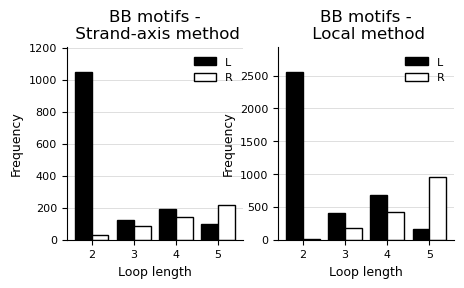

In [ ]:
from dataset.plots import plot_loop_length_category

fig,ax = plt.subplots(1, 2, figsize=(5, 2.5))
plot_loop_length_category(bb_motifs_by_strandaxis[np.abs(bb_motifs_by_strandaxis['handedness_magnitude'])>0.75], ax=ax[0])   
plot_loop_length_category(bb_motifs_local[np.abs(bb_motifs_local['handedness_magnitude'])>0.75], ax=ax[1]) 
ax[0].set_title("BB motifs -\n Strand-axis method") 
ax[1].set_title("BB motifs -\n Local method"); ax[1].set_ylabel(None)

Text(0, 0.5, '')

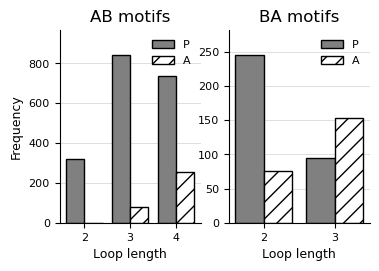

In [76]:
fig,ax = plt.subplots(1, 2, figsize=(4, 2.5))
plot_loop_length_category(ab_motifs[np.abs(ab_motifs['orientation_magnitude'])>0.75], ax=ax[0], loop_lengths=[2,3,4], category_col="orientation")
ax[0].set_title("AB motifs")
plot_loop_length_category(ba_motifs[np.abs(ba_motifs['orientation_magnitude'])>0.75], ax=ax[1], loop_lengths=[2,3], category_col="orientation")
ax[1].set_title("BA motifs"); ax[1].set_ylabel(None)

### What are those R hairpins with length 2?

None of these were observed in the paper. Maybe many of those are quite weak magnitude?

In [ ]:
bb_motifs_local[(bb_motifs_local["loop_len"] == 2) & (bb_motifs_local["handedness"] == "R")].head(10)

,Chain,strand1_start_idx,strand1_end_idx,strand2_start_idx,strand2_end_idx,strand1_start_res,strand1_end_res,strand2_start_res,strand2_end_res,loop_len,HairpinSequence,LoopSequence,FullChainSequence,PDB,handedness,handedness_magnitude
35,A,58,59,62,63,67,68,71,72,2,WFKNRT,KN,GYVPAVVIGTGYGAAVSALRLGEAGVQTLMLEMGQLWNQPGPDGNI...,4rek,R,0.007053
39,A,179,181,184,186,188,190,193,195,2,TVFVPNVY,VP,GYVPAVVIGTGYGAAVSALRLGEAGVQTLMLEMGQLWNQPGPDGNI...,4rek,R,0.087194
46,A,431,432,435,436,440,441,444,445,2,FADDFC,DD,GYVPAVVIGTGYGAAVSALRLGEAGVQTLMLEMGQLWNQPGPDGNI...,4rek,R,0.000206
104,A,138,141,144,150,1139,1142,1145,1151,2,VIKTVKSVGMIAG,VK,STPAITLENPDIKYPLRLIDKEVVNHDTRRFRFALPSPEHILGLPV...,5gv8,R,0.138283
155,A,20,24,27,32,45,48,49,54,2,FSVTRGATKGFVT,GA,ANIVGGIEYSINNASLCSVGFSVTRGATKGFVTAGHCGTVNATARI...,2h5c,R,0.810487
157,A,48,57,60,61,82,91,100,101,2,AVVGTFAARVFPGN,FP,ANIVGGIEYSINNASLCSVGFSVTRGATKGFVTAGHCGTVNATARI...,2h5c,R,0.063096
161,A,83,86,89,90,120,120,123,124,2,SFVTVRGS,VR,ANIVGGIEYSINNASLCSVGFSVTRGATKGFVTAGHCGTVNATARI...,2h5c,R,0.684031
242,A,90,91,94,95,128,129,132,133,2,VTISGN,IS,TVIPLQTTVQTPITLGSANNFAVIAGSSVTNTGATNITGDLGLSPG...,6eio,R,0.140925
244,A,100,101,104,108,138,139,142,146,2,TLTPGLYKS,TP,TVIPLQTTVQTPITLGSANNFAVIAGSSVTNTGATNITGDLGLSPG...,6eio,R,0.276572
257,A,90,98,101,102,133,141,144,145,2,WESVFSEFHDADA,DA,MISAAVDRVIGMENAMPWNLPADLAWFKLNKPVIMGRHTWESIGRP...,4pss,R,0.115181


# Writeout all hairpins in a single pdb file

In [ ]:
"""
Write an mmCIF with the first 20 β-hairpins that satisfy

    • loop_len ≤ 5
    • handedness == "L"
    • |handedness_magnitude| > 0.8
    • each flanking β-strand ≥ 5 residues

**Alignment frame (backbone method)**  
    origin      = CA of residue *before* the loop (res_pre = strand1_end)  
    +x (u-axis) = N→C vector of res_pre                              (backbone)  
    +y (v-axis) = CA_pre → CA_post, projected ⟂ u                    (across loop)  
    +z (w-axis) = u × v                                              (right-handed)

Each hairpin is copied into this frame (so all overlay) and stored in its own
chain HP_0001 … HP_0020 in **hairpins_backbone_aligned.cif**.
"""

from copy import deepcopy
import numpy as np
from Bio.PDB import MMCIFParser, MMCIFIO, Structure, Model, Chain, Vector

from dataset.io_utils  import fetch_mmcif_file
from dataset.geometry  import get_ca_from_residue, get_cb_from_residue
from dataset.motif_logic import compute_handedness_from_backbone_geometry   # already imported earlier

# ───────────────────────────── 1 · filter DataFrame
HP_DF = (
    all_hairpins_backbone
      .query(
          "loop_len == 2 and handedness == 'L' "
          "and abs(handedness_magnitude) > 0.8 "
          "and (strand1_end - strand1_start + 1) >= 5 "
          "and (strand2_end - strand2_start + 1) >= 5"
      )
      .head(20)        # keep first 20
      .reset_index(drop=True)
)
print(f"{len(HP_DF)} hairpins selected")

# ───────────────────────────── 2 · Bio.PDB setup
parser    = MMCIFParser(QUIET=True)
structure = Structure.Structure("BACKBONE_ALIGNED")
model0    = Model.Model(0)
structure.add(model0)

def np_vec(v: Vector):
    """Return numpy array from Bio.PDB.Vector"""
    return v.get_array()

# ───────────────────────────── 3 · iterate hairpins
for i, row in HP_DF.iterrows():
    pdb_id, cid = row["PDB"].lower(), row["Chain"]
    s1_start, s1_end = int(row["strand1_start"]), int(row["strand1_end"])
    s2_start, s2_end = int(row["strand2_start"]), int(row["strand2_end"])

    # source structure
    model_src = parser.get_structure(pdb_id, fetch_mmcif_file(pdb_id))[0]
    if cid not in model_src:
        continue
    chain_src = model_src[cid]

    try:
        res_pre  = chain_src[(" ", s1_end,   " ")]  # before loop
        res_post = chain_src[(" ", s2_start, " ")]  # after  loop
    except KeyError:
        continue

    # backbone frame
    ca_pre = np_vec(get_ca_from_residue(res_pre))
    ca_post= np_vec(get_ca_from_residue(res_post))
    if ca_pre is None or ca_post is None:
        continue

    u = np_vec(Vector(res_pre["C"].get_coord()) - Vector(res_pre["N"].get_coord()))
    u /= np.linalg.norm(u)

    v_raw = ca_post - ca_pre
    v_raw -= np.dot(v_raw, u) * u
    v = v_raw / np.linalg.norm(v_raw)

    w = np.cross(u, v)
    R = np.vstack((u, v, w)).T            # local→global; use R.T to rotate coords into frame

    # copy residues, transform
    new_chain = Chain.Chain(f"HP_{i+1:04d}")
    for resseq in range(s1_start, s2_end + 1):
        key = (" ", resseq, " ")
        if key not in chain_src:
            continue
        res = deepcopy(chain_src[key])
        for atom in res.get_atoms():
            xyz = atom.get_vector().get_array() - ca_pre   # translate to origin
            atom.set_coord(R.T @ xyz)                      # rotate into frame
        new_chain.add(res)

    model0.add(new_chain)

# ───────────────────────────── 4 · write mmCIF
out_cif = "hairpins_backbone_aligned.cif"
writer  = MMCIFIO()
writer.set_structure(structure)
writer.save(out_cif)

print(f"✓ saved {len(model0.child_list)} aligned hairpins → {out_cif}")


0 hairpins selected
✓ saved 0 aligned hairpins → hairpins_backbone_aligned.cif


# Other sanity checks

### Check C-b generation function

In [ ]:
# """
# Generate a minimal Ala residue, compute its Cβ with the library function
# `get_cb_from_residue`, and write the four atoms to *test_ala_cb.pdb*.

# Run this after you have installed the project (so that
# `dataset.geometry.get_cb_from_residue` is importable).
# """

# import math
# import numpy as np
# from pathlib import Path
# from Bio.PDB import Atom, Residue, Vector
# from dataset.geometry import get_cb_from_residue, CA_CB_BOND

# # ───────────────────────────────────────────────────────────────── backbone coords
# # realistic peptide geometry (Engh & Huber)
# CA = np.array([0.000, 0.000, 0.000])
# N  = np.array([1.458, 0.000, 0.000])                      # CA–N  1.458 Å
# C  = np.array([
#     1.525 * math.cos(math.radians(110.0)),                # CA–C  1.525 Å
#     1.525 * math.sin(math.radians(110.0)),
#     0.000
# ])

# # ───────────────────────────────────────────────────────────────── build residue
# res = Residue.Residue((" ", 1, " "), "ALA", "")
# res.add(Atom.Atom("N",  N,  0.0, 0.0, " ", "N",  1))
# res.add(Atom.Atom("CA", CA, 0.0, 0.0, " ", "CA", 2))
# res.add(Atom.Atom("C",  C,  0.0, 0.0, " ", "C",  3))

# # ───────────────────────────────────────────────────────────────── compute Cβ
# CB_vec = get_cb_from_residue(res)
# assert CB_vec is not None, "get_cb_from_residue returned None"
# CB = CB_vec.get_array()

# # ───────────────────────────────────────────────────────────────── write PDB
# lines = [
#     "ATOM      1  N   ALA A   1    %8.3f%8.3f%8.3f  1.00  0.00           N\n" % tuple(N),
#     "ATOM      2  CA  ALA A   1    %8.3f%8.3f%8.3f  1.00  0.00           C\n" % tuple(CA),
#     "ATOM      3  C   ALA A   1    %8.3f%8.3f%8.3f  1.00  0.00           C\n" % tuple(C),
#     "ATOM      4  CB  ALA A   1    %8.3f%8.3f%8.3f  1.00  0.00           C\n" % tuple(CB),
#     "TER\nEND\n",
# ]

# out = Path("test_ala_cb.pdb")
# out.write_text("".join(lines))
# print(f"wrote {out.resolve()}")

# # ═══════════════════════════════════════════════════════════════════════════════
# # optional sanity check
# import numpy as np
# def angle(a, b, c):
#     v1 = a - b
#     v2 = c - b
#     return math.degrees(
#         math.acos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
#     )

# print("CA–CB bond length  :", np.linalg.norm(CB - CA), "Å (expect", CA_CB_BOND, ")")
# print("∠N-CA-CB           :", angle(N, CA, CB), "°  (expect ≈109.5°)")
# print("∠C-CA-CB           :", angle(C, CA, CB), "°  (expect ≈109.5°)")


wrote /Users/shuber/Development/FoldingPrinciplesDataset/notebooks/test_ala_cb.pdb
CA–CB bond length  : 1.5220000000000002 Å (expect 1.522 )
∠N-CA-CB           : 101.02236461655833 °  (expect ≈109.5°)
∠C-CA-CB           : 101.02236461655835 °  (expect ≈109.5°)


/opt/anaconda3/envs/folding-dssp/lib/python3.9/site-packages/Bio/PDB/Atom.py:237: PDBConstructionWarning: Used element 'N' for Atom (name=N) with given element None
  warnings.warn(msg, PDBConstructionWarning)
/opt/anaconda3/envs/folding-dssp/lib/python3.9/site-packages/Bio/PDB/Atom.py:237: PDBConstructionWarning: Used element 'CA' for Atom (name=CA) with given element None
  warnings.warn(msg, PDBConstructionWarning)
/opt/anaconda3/envs/folding-dssp/lib/python3.9/site-packages/Bio/PDB/Atom.py:237: PDBConstructionWarning: Used element 'C' for Atom (name=C) with given element None
  warnings.warn(msg, PDBConstructionWarning)
